![NWU logo](NWUlogo.png)

***


# Exam 1

|      |      |
|:--- |:--- |
| Date | 2024-06-06 |
|Duration  | 2 weeks |
|Examiner | Pieter van Vuuren |
|Internal moderator | Prof Alwyn Hoffman |
|External moderator | Dr. Rensu Theart |

### Instructions
* This is a take-home, computer-based assignment.
* **This assignment is not group-work.** Bear in mind that you will also have to pass an oral examination during which you'll have to prove that you have done your own work in this assignment.
* **Steer clear of single-line solutions.** Your Python code should be as detailed as the code that we have developed during the class work and tutorials. As an example, we employed multiple lines of code in class to design Butterworth filters. In constrast the SciPy library solves the same problem in a single line of code, namely: `scipy.signal.butter()`. The latter approach won't earn you any credit in this assignment. Similarly "design" of an FIR filter by means of `scipy.signal.remez()` also won't earn you any credit in this assignment.
* Use this notebook as foundation for your assignment report.
* Save your file in notebook format ( .ipynb) and also print it out in PDF format. 
* Submit both documents via eFundi

***

### Problem statement

The attached video shows the position of a UFO as it traversed the field of view of a camera at the limits of its magnification. Your task is to track the position of the UFO and predict its position one step (frame) ahead in the future (although 5 steps ahead in the future would even be better).


### Hints
More information on how to interpret the 2D Fourier transform of an image can be found at:
* https://plus.maths.org/content/fourier-transforms-images
* https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm

Consult the following reference to read the individual frames of the video file:
* https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display.html

The position of the UFO can be modelled as a cross on the image, but also in terms of two 1D signals representing respectively the x- and y-coordinates of the center pixel of the UFO. The predicted position can therefore be represented in terms of two 1D graphs or a video showing the estimated / predicted UFO position. An easy approach to construct a video from a collection of images is by means of `ffmpeg` and more specifically as follows: 

`ffmpeg -y -framerate 10 -i /...path-to-image-folder.../image_%d.png -c:v libx264 -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" outputFileName.mp4`


### General instructions

Typically, the design of a final prediction algorithm entails the following:
1. analysis of the signal from two different perspectives;
2. a comparison of four different noise removal techniques; and
3. a comparison of two different prediction algorithms.

Be rigorous to motivate each and every design choice. Techniques should be compared on the basis of simulation results. Rigorous measurement of the efficacy of the various filtering and prediction algorithms is therefore important.

The rubricks that will be used for the assessment of your report and the oral examination are also attached to this assignment.

# Upload video and extract frames

Firstly, the video of the UFO is imported into the notebook and each frame exported for use throughout this notebook.

In [1]:
import subprocess
from IPython.display import Video
from PIL import Image

# Display the video
Video("Xfiles.mp4")


In [2]:
import cv2
import os

def extract_frames(video_path, output_folder, fps):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the video file
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return

    # Get the original video fps
    original_fps = video.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps / fps)
    
    current_frame = 0
    saved_frame = 0

    while True:
        ret, frame = video.read()
        if not ret:
            break
        
        # Save frame if it meets the interval condition
        if current_frame % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{saved_frame:04d}.png")
            cv2.imwrite(frame_filename, frame)
            saved_frame += 1
        
        current_frame += 1

    video.release()
    print(f"Extracted {saved_frame} frames to {output_folder}")

# Example usage
video_path = 'Xfiles.mp4'
output_folder = './frames/'
fps = 10  # Extract 1 frame per second

extract_frames(video_path, output_folder, fps)


Extracted 270 frames to ./frames/


# Part 1 - Analyses

Part 1 consists of the analyses of both the original video, as well as the position signal after developing and implementing a position tracking algorithm. Below, the two techniques for analyses is summarised, with their respective pros and cons.

* Analyses 1 - Time domain

Time domain analyses of the video as well as the position signal include visually inspecting the data of multiple frames in the video over time. This includes traveling speed, velocity and acceleration of the UFO, color schemes, brightness and other visual effect that influence image processing. Furthermore, noting if there are any seasonal components present in its movement, or if it seems random. Finally, visually one can also inspect the noise surrounding UFO, but only to a certain degree. Time domain analyses is especially advantagious when a prediction algorithm is developed.

This method prove to be very insightfull when analysing video content or simple one-dimentional signals, with few calculations needed. All signal analyses start with observing the behaviour of the data, time series analyses allows us to observe possible obstacles one may cross before starting to filter or predict the data. Although, this analyses technique provides much information of the data, the noise as well as measuremnet error is very difficult to determine. Thus, a second analyses technique is considered, namely frequency domain analyses. 

* Analyses 2 - Frequency domain

Frequency domain analyses include using algorithms such as the discrete fourier transform or its advanced version the fast fourier transform in both one dimensional and two dimentional forms to compute the frequency components present in the signals. Analysing the noise present in both the video as well as the position signal, can easily be done using the FFT. This result will be used to design filters with certain cutoff frequencies and roll offs. Furthermore, analysing the two dimentional frequency transform of a frame, one can design a filter mask as a technique to filter out unwanted frequencies in the video. And consequently, the 1D results is used to design several 1D filters, as seen in Part 2.

The FFT provides a fast and accurate way to determine the frequency components present in the data. However, this analyses technique does not provide where these components occur. If this was indeed desirable, one can alternatively use Wavelets to analyse frequency components over time, although for this practical was not considered. Furthermore, interpreting the results of a 2D FFT, can be non-intuitive and take some research to fully grasp. 

Further discussions of both techniques with their respective advantages and shortcommings, using both qualitative and quantitative interpretation, will be provided throughout Part 1. 

## Part 1.1 - Video Analyses

### Analyses 1 - Time domain

In [3]:
import cv2

def get_fps_and_resolution(video_path):
    # Open the video file
    video_capture = cv2.VideoCapture(video_path)
    
    # Get the frame rate
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    
    # Get the resolution
    width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Release the video capture object
    video_capture.release()
    
    return fps, (width, height)

# Example usage
video_path = 'Xfiles.mp4'
fps, resolution = get_fps_and_resolution(video_path)
print("Frames per second:", fps)
print("Resolution:", resolution)

Frames per second: 10.0
Resolution: (100, 100)


From the video we can assume that every frame was captured between the same interval. 

The movement of the UFO seems to follow a circular trend, crossing over to its original position, thus modeling the position of the UFO, time is a dependant variable (frame number in our case). Furthemrore, this circular movement will result in some 1D seasonal component, which need to be utilised for accurate position prediction. At the end of the video the UFO jumps from the left side of the frame to the right while dissapearing for 2 frames (Or could have been his friend xD).

Looking at the movement of the UFO, it can be noticed that the velocity as well as the acceleration is not constant. It can be seen that the UFO jumps quickly over several pixels to a position that is further away, which would have been captured with a higher frame rate. This also results in less smooth movement and could prove to be challenging for prediction. 

Contant noise exists in the background, which needs to be filtered out in order to track the UFO accurately and construct a position signal. More on noise analyses can be found in the Fast fourier transform section below, which takes a look at the frequency spectrum of the video.

From the code above it can be seen that the frames per second of the video is 100, and the resolution is 100x100 pixels, for a total of 270 frames (27s * 10 fps) in the video. An improvement in quality of video footage in the sense of fps and reslution, would have provided much more data and thus tracking and prediction algorithms would have been more accurate.  

### Analyses 2 - Frequency domain (FFT) 

In image processing, the Fast Fourier Transform (FFT) is commonly used to analyze the frequency components of an image. This involves performing the 2D FFT by applying the 1D FFT first across all rows and then across all columns, transforming the image from the spatial domain to the frequency domain. The resulting 2D frequency spectrum is a complex-valued matrix where each element represents a specific frequency component of the original image. The center of the spectrum represents low-frequency components, corresponding to slow variations in intensity and overall shapes and structures. Points farther from the center represent higher frequency components, which correspond to rapid intensity changes, such as edges and fine details.

In the 2D FFT spectrum, frequency components are often visualized as dots. Each dot represents a sinusoidal wave component of the image, with its brightness indicating the amplitude; brighter dots correspond to higher amplitude components, meaning these frequencies are more prominent in the image. The orientation of the dots relative to the center indicates the orientation of the sinusoidal gratings in the spatial domain. For instance, horizontal lines in the image appear as dots along the vertical axis in the frequency spectrum. While the amplitude and frequency are represented by the brightness and position of the dots, the phase information is encoded in their position relative to the center.

Each point in the 2D FFT spectrum corresponds to a 1D sinusoidal signal, where the coordinates (position) of the point give the frequency, the brightness represents the amplitude, and the orientation indicates the orientation of the grating in the image. The phase is encoded in the orientation and position relative to the center. By analyzing these frequency components, we can gain insights into the structure and features of the image, and apply various filtering techniques to enhance or modify the image. The FFT is a powerful tool for frequency domain analysis, enabling efficient and detailed examination of the underlying sinusoidal components [1]. 

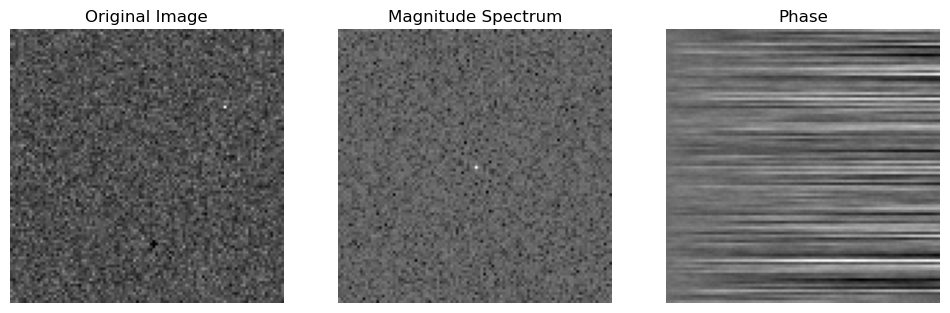

In [436]:
# Load the image
import numpy as np
from matplotlib import pyplot as plt
img_path = './frames/frame_0210.png'
image = Image.open(img_path)

# Convert image to grayscale
image_gray = image.convert('L')

# Convert image to numpy array
image_array = np.array(image_gray)

# Perform 2D FFT
fft2d = np.fft.fft2(image_array)
fft2d_shifted = np.fft.fftshift(fft2d)  # Shift the zero frequency component to the center

# Compute magnitude spectrum
magnitude_spectrum = 20*np.log10(np.abs(fft2d_shifted))  # Use log scale for better visualization
phase = np.unwrap(np.angle(fft2d_shifted))

# Plot the original image and the FFT result
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Magnitude Spectrum')
plt.imshow(magnitude_spectrum, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Phase')
plt.imshow(phase, cmap='gray')
plt.axis('off')

plt.show()

The FFT was taken for a few frames, and it can be concluded that much noise is present in the video. In some frames it is hard to even visually find the UFO. This noise will make it harder for the prediction algortihm to track the position of the UFO, and thus som eof it need to be filtered out (more on this in the next section).

## Part 1.2 - Position signal analyses

### Filtering for position signal algorithm

The first filtering approach that was considered was to create a mask around the origin of the frequency domain, to block the higher frequencies (outside of mask) and keep the lower frequencies inside the mask. Essentially this algorithm acts as a blurring function, which will then be used together with a threshold to isolate the UFO location. The results proved to be good, but a threshold could not be found that successfully finds the UFO in every frame. Some frames have more than one pixel above the threshold, while other have none. Moving the cutoff frequency of the filter, does improve the result but a more consistant approach was needed.

Another approach was considered that makes use of a blurring Kernel and a convolutional sum approach. This essentially moves the kernel over the image performing the convolutional operation (basically a weighted average filter). The kernel is overlaid onto the input image by placing its center element on each pixel of the image, one at a time. The products obtained from the element-wise multiplication are summed up to produce a single value. The resulting sum becomes the value of the output pixel at the corresponding position in the output image. The corners was wrapped, and not zero padding as this interfered with the threshold algorithm [2][3].

The postion tracking algorithm (see Appendix A) was ran on a seperate python script and the resulting coordinates was save to a .csv file which will be imported and analysed in the next section.

### Analyses 1 - Time domain analyses

Results of the tracking algortihm is imported and plotted below, and again time domain analyses is done, to understand and determine the underlying true signal from the tracking algortihm.

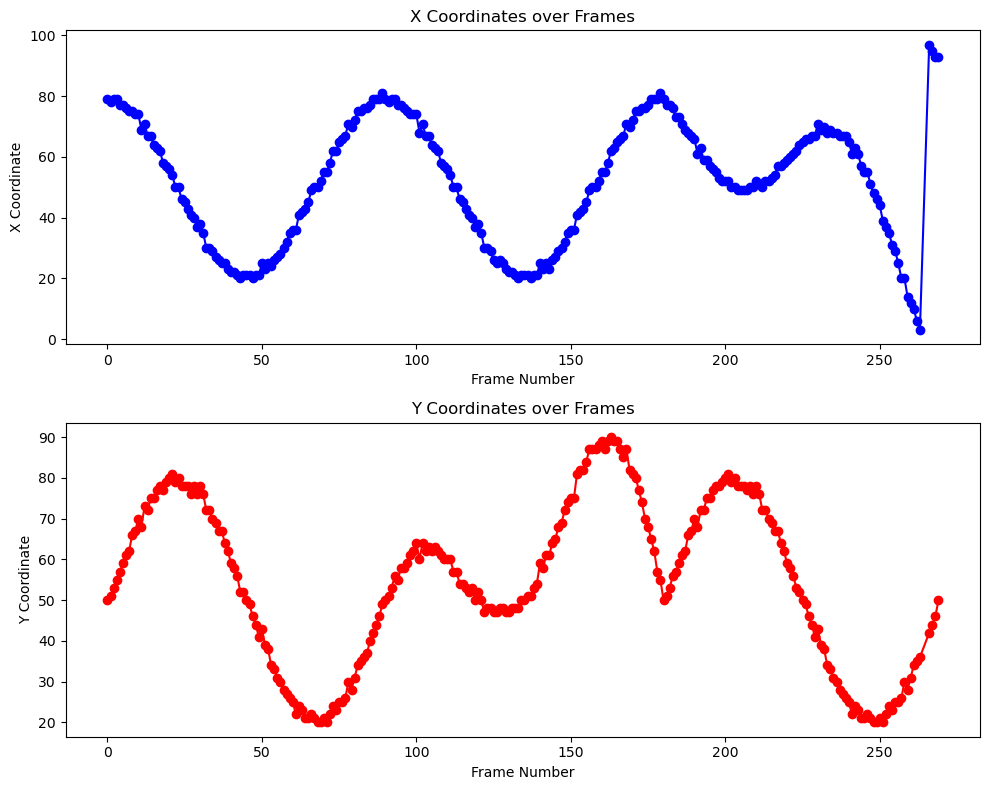

In [11]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
csv_file_path = "UFO_coordinates.csv"
df = pd.read_csv(csv_file_path)

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the x-coordinates against frame numbers
ax1.plot(df['frame'], df['x_coord'], marker='o', linestyle='-', color='b')
ax1.set_title('X Coordinates over Frames')
ax1.set_xlabel('Frame Number')
ax1.set_ylabel('X Coordinate')

# Plot the y-coordinates against frame numbers
ax2.plot(df['frame'], df['y_coord'], marker='o', linestyle='-', color='r')
ax2.set_title('Y Coordinates over Frames')
ax2.set_xlabel('Frame Number')
ax2.set_ylabel('Y Coordinate')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

It can be noted that the 'measured' results does contain some noise in the signals. This results in small variations along the underlying trend. This noise is due to both the tracking algorithm's prediction error. Which is caused when blurring the pixels and the cross (UFO) spreading over several pixels, which leads to prediction error of one or two pixels. Furthermore, a slow frame rate causes us to mis transitions between frames, causing the UFO to 'jump' from one coordinate to the next. Filtering in Part 2 will smooth out this position signal, which will allow more accurate prediction by minimising the overall prediction error, and estimating a continuous signal over the current discrete results. This will improve the prediction models in Part 3. 

The video is unable to be played inside the notebook, thus a frame from the UFO tracking results is shown below.

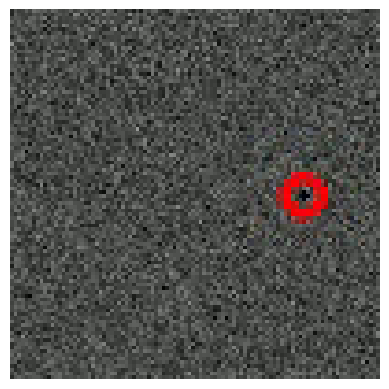

In [451]:
frame_number = 0  # choose any frame 0 -> 269

# Path to your video file
video_path = "UFO_tracking.mp4"

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the specified frame
    ret, frame = cap.read()

    # Close the video file
    cap.release()

    if ret:
        # Convert the frame from BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the specified frame using Matplotlib
        plt.imshow(frame_rgb)
        plt.axis('off')  # Hide the axis
        plt.show()
    else:
        print(f"Error: Could not read frame {frame_number}.")




The centre of the red circle, marks the prediction of the UFO's location. Analysing the video completely, we can conclude that the prediction algorithm prove to be very accurate with slight measuremnt errors, within a few pixels.

Take note that further time series analyses, in the form of both qualitative and quantitative interpretations, will be done in Part 3 when the prediction models are developed. This includes calculations such as auto correlation, stationarity tests and normal distribution tests.

### Analyses 2 - Frequency domain analyses

The FFT was performed on both x- and y-coordinate 1D position signals, using a blackman window to smooth out the sidebands in the frequency domain, and plotting the results. Take note that the x-axis of this frequency transform is the frame rate of the video, thus sampling at 10 fps, gives Nyquist frequency of 5 fps.

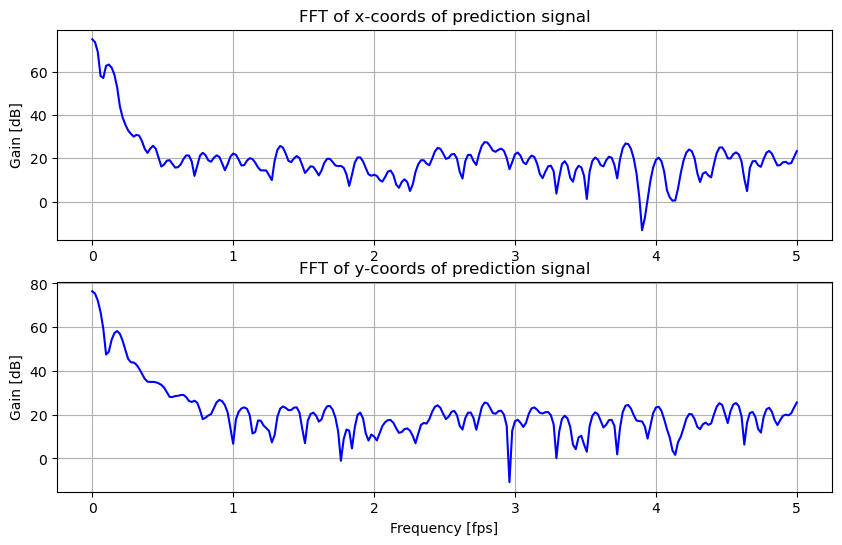

In [457]:
from scipy import signal as sig

df = pd.read_csv(csv_file_path)
seinx = df['x_coord']
seiny = df['y_coord']

# Number of samples in the signal
N = len(seinx)

# Sampling frequency (assuming each frame corresponds to a unit time interval)
Fs = 10  # 10 frame per unit time

M = int(np.ceil(np.log2(N)))		            
Nfft = 2**M
df = Fs / Nfft

window = sig.windows.blackman(N)
X = np.fft.fft(seinx*window,Nfft)				   
X_abs = np.abs(X)					            
f = np.linspace(0,Fs/2,Nfft//2)		            

plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.title('FFT of x-coords of prediction signal')
plt.plot(f[0:Nfft//2],20*np.log10(X_abs[0:Nfft//2]),'b')
# plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
plt.grid()

# Number of samples in the signal
N = len(seiny)

M = int(np.ceil(np.log2(N)))		            
Nfft = 2**M
df = Fs / Nfft

window = sig.windows.blackman(N)
X = np.fft.fft(seiny*window,Nfft)				   
X_abs = np.abs(X)					            
f = np.linspace(0,Fs/2,Nfft//2)	

plt.subplot(2,1,2)
plt.title('FFT of y-coords of prediction signal')
plt.plot(f[0:Nfft//2],20*np.log10(X_abs[0:Nfft//2]),'b')
plt.xlabel('Frequency [fps]')
plt.ylabel('Gain [dB]')
plt.grid()

Observing both frequency plots, it can be noted that the weight of the underlying signal lies in the lower frequencies, when analysing the gain in decibels of the transform. Furthermore, a lot of noise from the measurements can be seen from frequencies 0.5 and above, having lower gain andrapid fluctiations throughout higher frequencies, which is tipical characteristics of noise. Most of this noise will be attempted to be removed in Part 2.

# Part 2 - Filtering techniques

## Filter 1 - FIR

A Finite Impulse response filter is represented by the following difference equation,

$$ y[n] = \sum_{k=0}^{M} b_k x[n-k] $$

where $b_k$ represents the FIR coefficients, and K + 1 equal the FIR filter length [4]. The FIR filter operations involve multiplying the filter inputs by their corresponding coefficients and accumulating them, due to to the number of inputs the difference equation needs, lead to a real time delay. 

FIR filters exibit many favourable properties, of which a linear phase is one of them, which means signals in the passband will suffer no dispersion (different frequency compoenents having different delay through a system) [5]. To design a low pass FIR filter, we use the ideal LPF equation for two cases,

$$
h_d[n] = 
\begin{cases}
\frac{\sin(\omega_c n)}{\pi n} & \text{for } n \neq 0 \\
\frac{\omega_c}{\pi} & \text{for } n = 0
\end{cases}
$$

and after multiplying the ideal LPF with the window function used,

$$
h[n] = h_d[n] \cdot w[n].
$$

Moreover, all design decisions as well as results ito qualitative and quantative interpretation will be discussed throughout development.

##### Filter design

The Windowed Fourier series approach was considered to design a low-pass FIR filter. This method provides a choice of window function, which allows better control not only for the transition between the pass- and stop-bands but also the gain and attenuation of both. While other techniques such as frequency sampling method, we design a optimum filter, and tune the roll offs afterwards. Although, it will also work for our application, it generally takes longer to design and find the perfect coefficients. Lastly, improving the solution using the Parks McCellan algorithm was not considered due to lack of experience and sufficient performance of the existing solution.

Using the frequency analyses in Part 1.2 of the position signal, several cut-off frequencies was considered:

Moving the cutoff frequencies higher such as,

* omega_pass = 0.25 
* omega_stop = 0.35

passes too much noise or introduces a slight ripple at the troughs of the sinusoid.

Thus, cutoff was chosen to be,

* omega_pass = 0.1 
* omega_stop = 0.2

lower cutoffs will not pass the desired signal. 

A general order of the FIR filter was calculated using the Kaiser and Bellanger formulas, as seen from the code below.

In [458]:
from scipy import signal

omega_pass = 0.1 
omega_stop = 0.2 
Fsample = 1
alfa_pass = 1
alfa_stop = 10

# Common calculations
delta_p = 1 - 10**(alfa_pass / (-20))
delta_s = 10**(alfa_stop / (-20))
w_s = 2 * np.pi * omega_stop / Fsample
w_p = 2 * np.pi * omega_pass / Fsample
w_c = (w_s + w_p) / 2
delta_w = w_s - w_p

# Kaiser formula
N = (-20*np.log10((delta_p*delta_s)**(1/2)) - 13) / (14.6*(w_s-w_p)/(2*np.pi))
print('Kaiser formula')
print('N : ',N)

# Bellanger formula
N = (-2*np.log10(10*delta_p*delta_s) / (3*(w_s - w_p)/(2*np.pi))) - 1
print('Bellanger formula')
print('N : ',N)

# Calculate M for various windows
Mhann = 3.11 * np.pi / delta_w
Mhamm = 3.32 * np.pi / delta_w
Mblack = 5.56 * np.pi / delta_w
print('M (hanning): ',Mhann)
print('M (hamming): ',Mhamm)
print('M (blackman): ',Mblack)

Kaiser formula
N :  1.120373156426731
Bellanger formula
N :  2.090496538922019
M (hanning):  15.549999999999999
M (hamming):  16.599999999999998
M (blackman):  27.799999999999997


M of 10 was chosen, which is slightly less than recommended. It proved to be sufficient due to good performance ito gain, attenuation and roll off, and also to minimise large delays present in higher order filters.

The Hamming window provided the best results ito passband gain and stopband attenuation. Blackman window has too much attenuation in passband, which can be compensated for by increasng the filter order, but again will increase the filter's delay due to increase in size of difference equation. Furthermore, the hanning window had longer roll off, although could have worked for this filter order as well.

The filter coefficient was calculated using the ideal lowpass filter equations descibed earlier, together with the hamming window equation [4].

The Hamming window function $w[n]$ is given by:

$$
w[n] = 0.54 - 0.46 \cos\left(\frac{2\pi n}{N-1}\right), \quad 0 \leq n \leq N-1
$$

where $N$ is the window length and $n$ is the sample index.

Order of implemented filter:  21
Filter coefficients:  [ 9.35561240e-19  2.93324577e-03  6.35175091e-03  3.78865096e-03
 -1.24062151e-02 -3.43774677e-02 -3.19070987e-02  2.65705536e-02
  1.38067570e-01  2.51720344e-01  3.00000000e-01  2.51720344e-01
  1.38067570e-01  2.65705536e-02 -3.19070987e-02 -3.43774677e-02
 -1.24062151e-02  3.78865096e-03  6.35175091e-03  2.93324577e-03
  9.35561240e-19]
Passband corner:  -0.7217752875709063  dB,  0.1005859375  Hz
Cutoff frequency:  -6.10679421835672  dB,  0.150390625  Hz
Stopband corner:  -22.208401109391026  dB,  0.2001953125  Hz


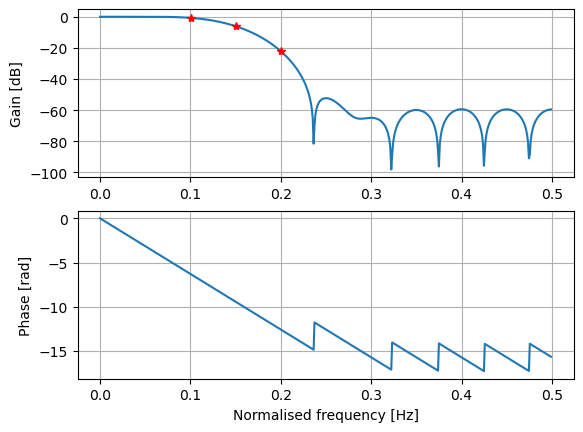

In [488]:
# Calculate and implement time domain window
M = 10
venster = np.zeros(2*M+1)
idealeLPF = np.zeros(2*M+1)
finaleLPF = np.zeros(2*M+1)
indekse = np.arange(-M,M+1,1)
k = 0
n = -1*M
while n <= M:
	#venster[k] = 1											# square window
	# venster[k] = 0.5 * (1 + np.cos(np.pi * n / M))			# Hanning window
	venster[k] = 0.54 + (0.46 * np.cos(np.pi * n / M))		# Hamming window
	# venster[k] = 0.42 + (0.5*np.cos(np.pi * n / M)) + (0.08*np.cos(2*np.pi * n / M))	# Blackman window
	if (n == 0):
		idealeLPF[k] = w_c / np.pi
	else:
		idealeLPF[k] = np.sin(w_c*n)/(np.pi*n)
	n = n + 1
	k = k + 1
finaleLPF = idealeLPF * venster
print('Order of implemented filter: ',venster.size)
print('Filter coefficients: ',finaleLPF)

# Calculate frequency response
numerator = finaleLPF
denominator = 1
w,h = signal.freqz(numerator,denominator)
gain = abs(h)
gaindB = 20*np.log10(abs(h))		# gain [dB]
phase = np.unwrap(np.angle(h))

index = np.where(w >= w_p)			# verify edge frequencies
pIndex1 = index[0][0]
print('Passband corner: ',gaindB[pIndex1],' dB, ',w[pIndex1]*Fsample/(2*np.pi),' Hz')
index = np.where(w >= w_c)			# verify edge frequencies
pIndex2 = index[0][0]
print('Cutoff frequency: ',gaindB[pIndex2],' dB, ',w[pIndex2]*Fsample/(2*np.pi),' Hz')
index = np.where(w >= w_s)			# verify edge frequencies
pIndex3 = index[0][0]
print('Stopband corner: ',gaindB[pIndex3],' dB, ',w[pIndex3]*Fsample/(2*np.pi),' Hz')

plt.figure(1)						# plot frequency response
plt.subplot(2,1,1)
plt.plot(w*Fsample/(2*np.pi),gaindB)
plt.ylabel('Gain [dB]')
plt.grid('true')
plt.plot(w[pIndex1]*Fsample/(2*np.pi),gaindB[pIndex1],'r*')
plt.plot(w[pIndex2]*Fsample/(2*np.pi),gaindB[pIndex2],'r*')
plt.plot(w[pIndex3]*Fsample/(2*np.pi),gaindB[pIndex3],'r*')
plt.subplot(2,1,2)
plt.plot(w*Fsample/(2*np.pi),phase)
plt.grid('true')
plt.ylabel('Phase [rad]')
plt.xlabel('Normalised frequency [Hz]')
plt.show()

Observing the verified three corner frquencies of the calculated LFP we can conclude the following.

* Pass band corner has almost no attenuation. 
* Cutoff freq is close to desired -3 dB.
* The stop band corner is attenuated enough to get rid of most noise. 

Next, the coefficients of the numerator is used to construct the difference equation, and consequently produce the filtered signal. The process was first followed for the x-coordinates of the 2D UFO position, and later repeated for the y-coordinates.

##### x-coordinates

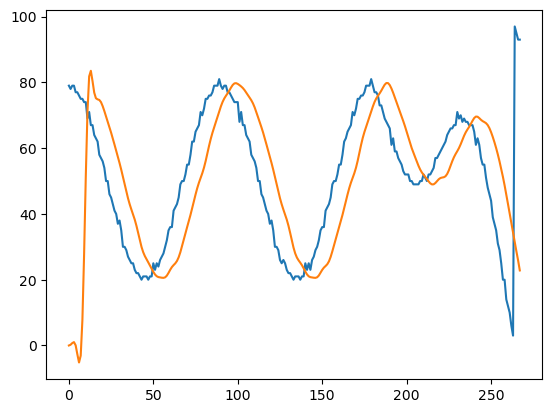

In [489]:
filtered_signal = np.zeros(len(x_coords))
for n in range(len(x_coords)):
    y_n = 0
    for k in range(len(numerator)):
        if n - k >= 0:
            y_n += numerator[k] * x_coords[n - k]
    for k in range(1, denominator):
        if n - k >= 0:
            y_n -= denominator * filtered_signal[n - k]
    filtered_signal[n] = y_n / denominator

t = np.arange(0, len(x_coords), 1)
plt.plot(t, x_coords)
plt.plot(t, filtered_signal)

From the figure above,

The delay introduced by the FIR filter is due to the order off the difference equation, although this ideally want to be minimised, some delay is always going to be present for orders greater than 1. Further, the order of the filter can not be too low as this will provide a slow roll off and start to attenuate the passband signal or pass the unwanted stop band. Lastly, the last part of the signal was not filtered due to the lack of number of samples left to accomodate the entire difference equation size.

A design decision was made between the attenuation vs delay by adjusting the order of filter and the window type. In our case accuracy is more important than delay. Delay can always be compensated for by also adding a delay to the original signal before the results are compared. 

For a causal FIR filter with an odd number of coefficients (our case N = 21), the delay is typically equal to N/2 - 1, because FIR filters are often symmetric around the middle coefficient. Thus the delay was chosen as M = 10.

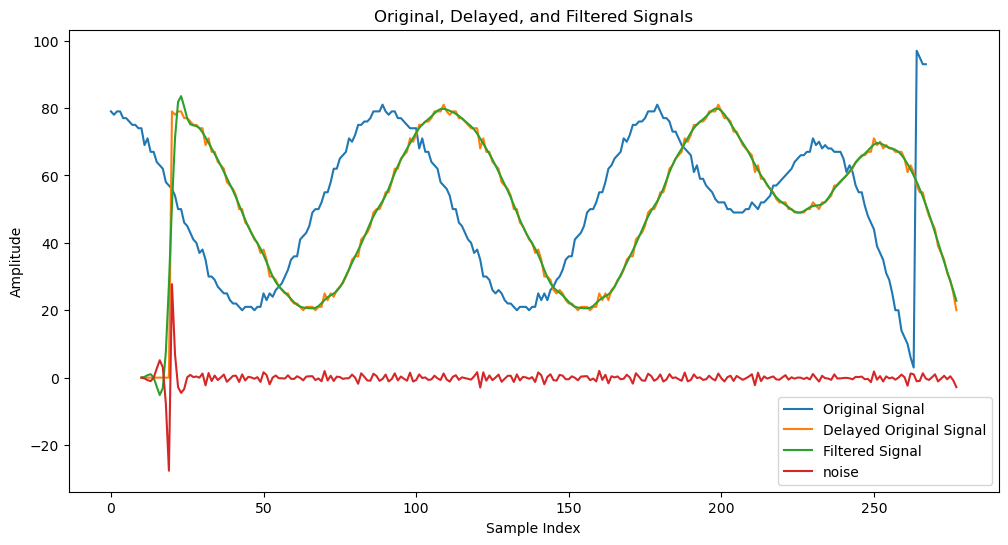

In [490]:
# Define the delay (in samples)
delay = M

# Create a delayed version of the original signal
delayed_signal = np.zeros_like(x_coords)
if delay < len(x_coords):
    delayed_signal[delay:] = x_coords[:-delay]

noise = delayed_signal - filtered_signal

t = np.arange(0, len(x_coords), 1)
plt.figure(figsize=(12, 6))
plt.plot(t, x_coords, label='Original Signal')

t = np.arange(M, len(x_coords) + M, 1)
plt.plot(t, delayed_signal, label='Delayed Original Signal')
plt.plot(t, filtered_signal, label='Filtered Signal')
plt.plot(t, noise, label='noise')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Original, Delayed, and Filtered Signals')
plt.show()

Now that the filtered signal and the orginal signal is again in phase, we can calculate the noise removed, and quantatively verify its normal gaussian distribution. Take note that the first part of the estimated noise is left out due to a the large error introduced by the actual prediction only starting at around 20 samples.

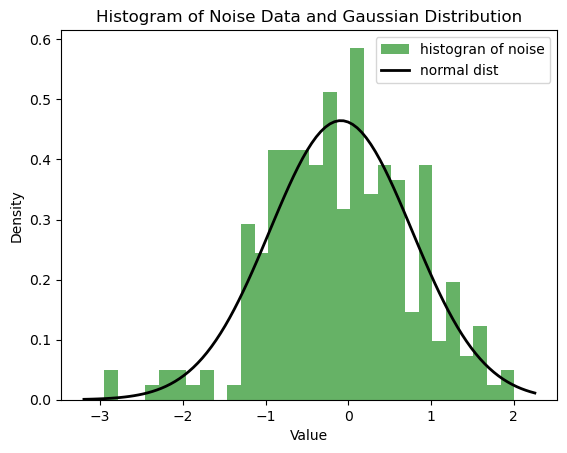

In [499]:
from scipy.stats import norm
x_noise = noise[20:] #excluding error that is due to delay of FIR filters

# Plot histogram of the data
plt.hist(x_noise, bins=30, density=True, alpha=0.6, color='g', label = 'histogran of noise')

# Plot Gaussian distribution curve for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(x_noise), np.std(x_noise))
plt.plot(x, p, 'k', linewidth=2, label = 'normal dist')
# plt.xlim(-15,15)
plt.legend()

plt.title("Histogram of Noise Data and Gaussian Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

In conclusion, the FIR low pass filter was designed good enough to remove most of the noise introduced by the position tracking algorithm. For practical applications some system specifications based on accuracy is often provided, and can be used to further improve the system by adjusting the order or window type. The filtered signal could have been smoothed more by one or two pixels at some places, but for the resolution we are working with is accurate enough. Other application where resolution is more, this will cuase a larger relative error and may not be sufficient. The same approach will be followed for the y coordinates position signal.

##### y-coordinates

The same approach with less explanation will be done for the y-coordinates signal.

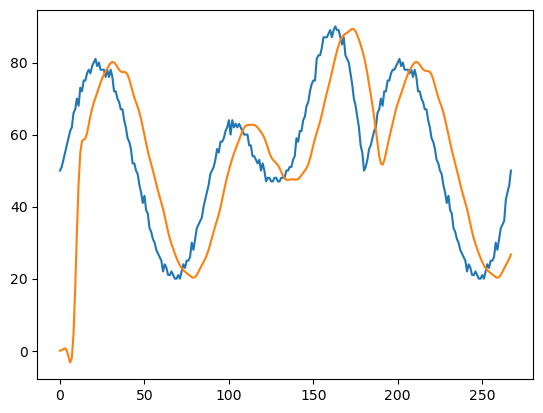

In [500]:
filtered_signal = np.zeros(len(y_coords))
for n in range(len(y_coords)):
    y_n = 0
    for k in range(len(numerator)):
        if n - k >= 0:
            y_n += numerator[k] * y_coords[n - k]
    for k in range(1, denominator):
        if n - k >= 0:
            y_n -= denominator * filtered_signal[n - k]
    filtered_signal[n] = y_n / denominator

t = np.arange(0, len(y_coords), 1)
plt.plot(t, y_coords)
plt.plot(t, filtered_signal)

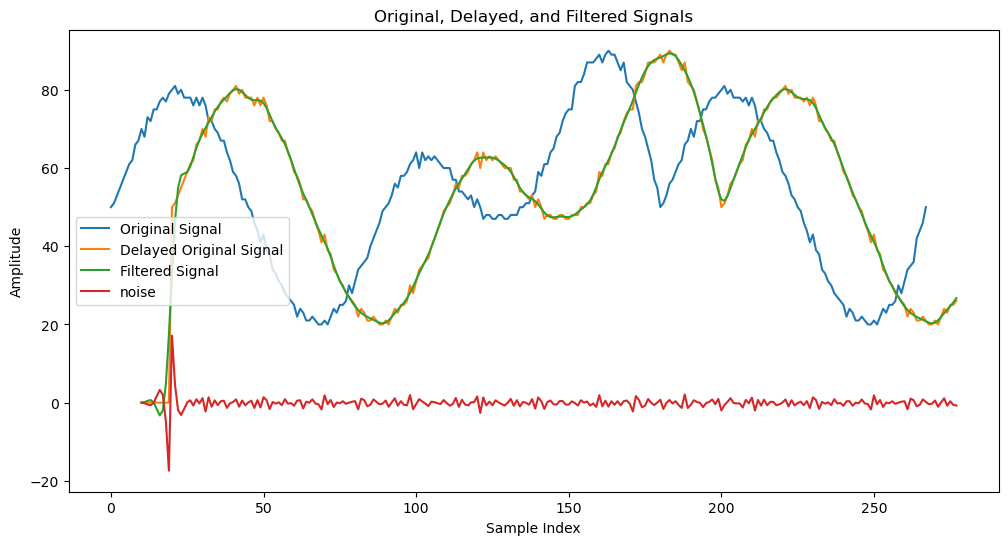

In [502]:
# Define the delay (in samples)
delay = M

# Create a delayed version of the original signal
delayed_signal = np.zeros_like(y_coords)
if delay < len(y_coords):
    delayed_signal[delay:] = y_coords[:-delay]

noise = delayed_signal - filtered_signal

t = np.arange(0, len(y_coords), 1)
plt.figure(figsize=(12, 6))
plt.plot(t, y_coords, label='Original Signal')

t = np.arange(M, len(y_coords) + M, 1)
plt.plot(t, delayed_signal, label='Delayed Original Signal')
plt.plot(t, filtered_signal, label='Filtered Signal')
plt.plot(t, noise, label='noise')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Original, Delayed, and Filtered Signals')
plt.show()

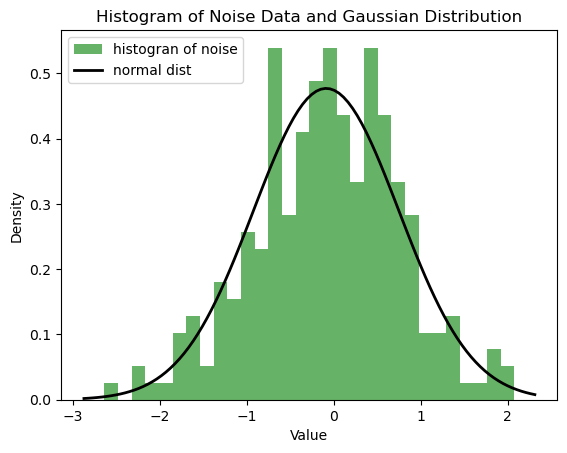

In [503]:
x_noise = noise[20:] #excluding error that is due to delay of FIR filters

# Plot histogram of the data
plt.hist(x_noise, bins=30, density=True, alpha=0.6, color='g', label = 'histogran of noise')

# Plot Gaussian distribution curve for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(x_noise), np.std(x_noise))
plt.plot(x, p, 'k', linewidth=2, label = 'normal dist')
# plt.xlim(-15,15)
plt.legend()

plt.title("Histogram of Noise Data and Gaussian Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

Same conclusion as from the x-coords results.

## Filter 2 - PCA

Principal componenet analyses is a powerfull tool to reducing the dimensionality of datasets while preserving crucial information. It does this by transforming the original variables into a set of new, uncorrelated variables called principal components [6]. These principal compoenents are normalized linear combinations of the original features of the data.

Before we apply the steps for PCA, for completeness the input signal was padded using interpolation to multiples of the window size chosen. This ensured the X matrix to be a complete representation of the input signal using a certain window size, otherwise the matric does not represent the entire signal, and thus the input signal is not filtered until the end. Alternatively one could have used zero padding, but for accuracy linear interpolation is a better option.

This interpolation algorithm determines an even distributed amount of points based on the size difference of the input signal and the desired length output signal. Then it used the two adjacent points together with a linear function to determine the padded value. 

##### x-coordinates

In [562]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

Nwindow = 10  # Desired window size

original_length = len(x_coords)
new_length = ((original_length + Nwindow - 1) // Nwindow) * Nwindow
N = new_length

x_original = np.linspace(0, 1, original_length)
x_new = np.linspace(0, 1, new_length)
interpolator = interp1d(x_original, x_coords, kind='linear')

intr_x_coords = interpolator(x_new)
print(f"Length of interpolated signal: {len(intr_x_coords)}")

Length of interpolated signal: 270


Step 1: construct the X matrix

The first step is to standardize the data by subtracting the mean.

In [563]:
# Nwindow = 10 
X = np.zeros((Nwindow,N//Nwindow))
print(f"X shape: {X.shape}")
(Nr, Nc) = X.shape

k = 0
for n in range(0, Nc):
    X[:,n] = intr_x_coords[k:k+Nwindow]
    k = k + Nwindow

mu = np.mean(X,1)
print(f"mu shape: {mu.shape}")

for n in range(0,Nc):
    X[:,n] = X[:,n] - mu

X shape: (10, 27)
mu shape: (10,)


Step 2: Determine the covariance matrix of X

A covariance metrix is a square matrix that represents the relationship between two items in a random vector. The diagonal values represent the variance, while the non-diagonal values represent the covariance. 

The covariance of two variables $x$ and $y$ is given by:
$$cov(\mathbf{x},\mathbf{y}) = \frac{\sum_{n=1}^N (x_n-\bar{x})(y_n-\bar{y})}{(N-1)}$$

Positive variance means the two variables has a positive relationship.

In [564]:
Cx = np.cov(X)

Step 3: Determine the eigenvalue decomposition of Cx

Step three determines the aigenvalues and eigenvectors of the covariance matrix. The eigenvectors represent the directions of maximum variance, and the corresponding eigenvalues indicate the magnitude of the variance along those directions [6]. The cumulative summation of the eigenvalues are also calculated and normalised to determine each eigenvalues contribution to the data.

In [565]:
eigval, eigvec = np.linalg.eig(Cx)

# Sort eigenvalues and eigenvectors
sorted_indices = np.argsort(eigval)[::-1]
sorted_eigval = eigval[sorted_indices]
sorted_eigvec = eigvec[:, sorted_indices]

Kumsom = np.cumsum(eigval)
Kumsom = 100*Kumsom/np.amax(Kumsom)

Step 4: use a scree plot to determine how many principal components to use in reconstruction

A scree plot is used to plot these eigenvalues (N = 10, due to window size chosen), and their percentage contribution. The eigenvalues are sorted according to weight as seen from the scree plot.

Text(0.5, 0, 'Index []')

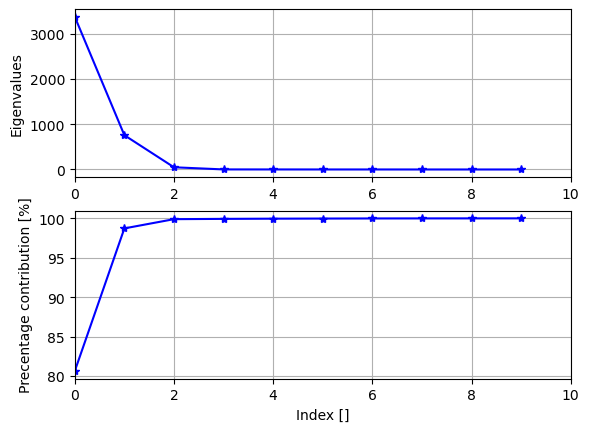

In [566]:
plt.subplot(2,1,1)
plt.plot(eigval,'b-*')
plt.grid('true')
plt.xlim(0,10)
plt.ylabel('Eigenvalues')
plt.subplot(2,1,2)
plt.plot(Kumsom,'b-*')
plt.grid('true')
plt.ylabel('Precentage contribution [%]')
plt.xlim(0,10)
plt.xlabel('Index []')

Clearly, a converging shape is observed, with most of the weight contributed by eigenvalues 1 through 3 (0->2 in plot), which represents our principal compoenents. Thus for reconstruction we will use the first 3 eigenvalues that represents the majority of the contribution of the entire data, while eliminating unwanted eigenvalues which most likely represents the noise.

Step 5: Transform and reconstruct

Lastly, we multiply the original standardized data by the selected principal components to obtain the new, lower-dimensional representation of the data. Finally adding the mean back to denormalise the result and transforming it from a matrix of size X back to a 1D signal.

In [567]:
Nuse = 3
A = np.zeros(Cx.shape)

for n in range(0, Nuse):
    A[n,:] = eigvec[:,n]
print(f"A shape: {A.shape}")

y = A@X

xk = A.T @ y

for n in range(0,Nc):
    xk[:,n] = xk[:,n] + mu

out = np.zeros(N)

k = 0
for n in range(0,Nc):
    out[k:k+Nwindow] = xk[:,n]
    k = k + Nwindow

noise = intr_x_coords - out
pca_xfiltered = out

A shape: (10, 10)


Text(0, 0.5, 'Ampltidue')

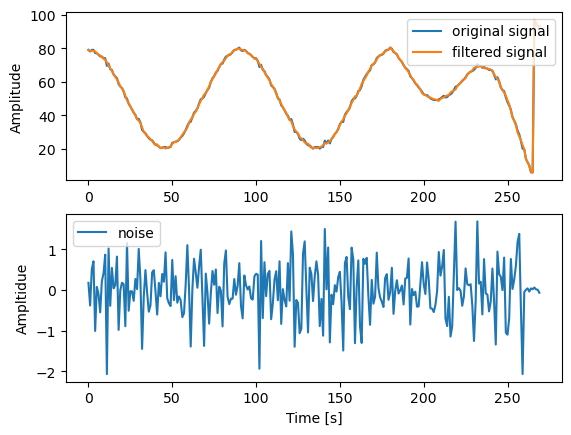

In [568]:
t = np.arange(0,N)
plt.subplot(2,1,1)
plt.plot(t,intr_x_coords, label = 'original signal')
plt.plot(t,out, label = 'filtered signal')
plt.ylabel('Amplitude')
# plt.xlim(0,250)
plt.legend()
plt.subplot(2,1,2)
plt.plot(t,noise, label = 'noise')
plt.legend()
# plt.xlim(0,250)
plt.xlabel('Time [s]')
plt.ylabel('Ampltidue')

In conclusion,

Higher window size such as 25 is not as accurate in representing the signal without introducing more principal compoenents (eigenvectors), which consequently introduces more noise. Moreover, too small of a window size, provides less eigenvectors, thus harder to distinguish between underlying signal and noise. 

Using less eigenvectors cuases under representation of the signal and thus loosing important information. Additionally, using more eigenvectors includes the unwanted noise.

Finally, testing if the difference removed is normally distributed and truely noise, again a histogram is plotted.

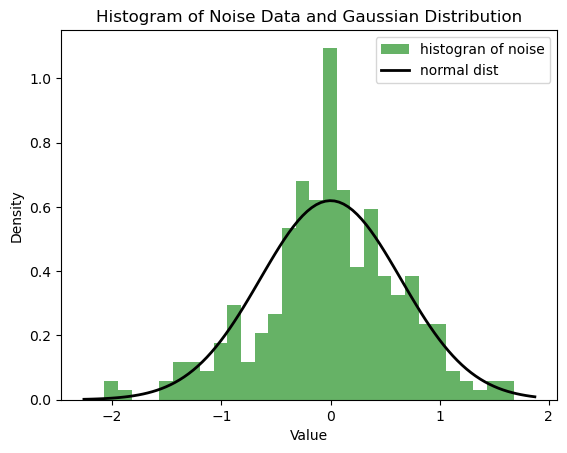

In [569]:
from scipy.stats import norm
x_noise = noise

# Plot histogram of the data
plt.hist(x_noise, bins=30, density=True, alpha=0.6, color='g', label = 'histogran of noise')

# Plot Gaussian distribution curve for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(x_noise), np.std(x_noise))
plt.plot(x, p, 'k', linewidth=2, label = 'normal dist')
# plt.xlim(-15,15)
plt.legend()

plt.title("Histogram of Noise Data and Gaussian Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

From both the histogram plot and visually observing the filtered response, we can conclude that the filter using PCA does accurately remove most of the noise, and is sufficient for this practical. Again, slight uncertainties where smoothing could have been improved is very small compared to the reletive scale for our video resolution.

##### y-coordinates

The process of PCA filtering is repeated for the y-coordinates with less explanation.

In [570]:
Nwindow = 10  # Desired window size

original_length = len(y_coords)
new_length = ((original_length + Nwindow - 1) // Nwindow) * Nwindow
N = new_length

x_original = np.linspace(0, 1, original_length)
x_new = np.linspace(0, 1, new_length)
interpolator = interp1d(x_original, y_coords, kind='linear')

intr_y_coords = interpolator(x_new)
print(f"Length of interpolated signal: {len(intr_y_coords)}")

Length of interpolated signal: 270


In [571]:
X = np.zeros((Nwindow,N//Nwindow))
print(f"X shape: {X.shape}")
(Nr, Nc) = X.shape

k = 0
for n in range(0, Nc):
    X[:,n] = intr_y_coords[k:k+Nwindow]
    k = k + Nwindow

mu = np.mean(X,1)
print(f"mu shape: {mu.shape}")

for n in range(0,Nc):
    X[:,n] = X[:,n] - mu

X shape: (10, 27)
mu shape: (10,)


In [572]:
Cx = np.cov(X)

In [573]:
eigval, eigvec = np.linalg.eig(Cx)

# Sort eigenvalues and eigenvectors
sorted_indices = np.argsort(eigval)[::-1]
sorted_eigval = eigval[sorted_indices]
sorted_eigvec = eigvec[:, sorted_indices]

Kumsom = np.cumsum(eigval)
Kumsom = 100*Kumsom/np.amax(Kumsom)

Text(0.5, 0, 'Index []')

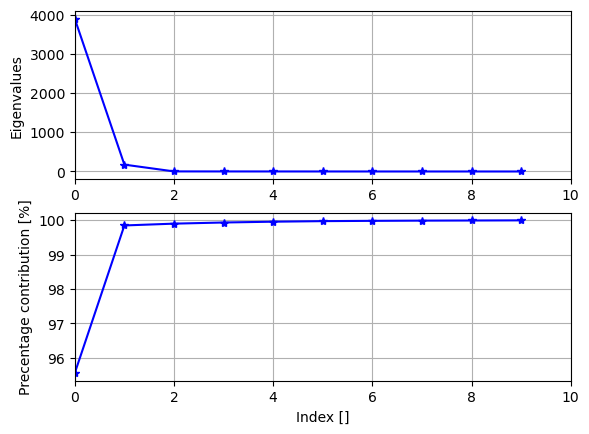

In [574]:
plt.subplot(2,1,1)
plt.plot(eigval,'b-*')
plt.grid('true')
plt.xlim(0,10)
plt.ylabel('Eigenvalues')
plt.subplot(2,1,2)
plt.plot(Kumsom,'b-*')
plt.grid('true')
plt.ylabel('Precentage contribution [%]')
plt.xlim(0,10)
plt.xlabel('Index []')

In [575]:
Nuse = 3
A = np.zeros(Cx.shape)

for n in range(0, Nuse):
    A[n,:] = eigvec[:,n]
print(f"A shape: {A.shape}")

y = A@X

xk = A.T @ y

for n in range(0,Nc):
    xk[:,n] = xk[:,n] + mu

out = np.zeros(N)

k = 0
for n in range(0,Nc):
    out[k:k+Nwindow] = xk[:,n]
    k = k + Nwindow

noise = intr_y_coords - out
pca_yfiltered = out

A shape: (10, 10)


Text(0, 0.5, 'Ampltidue')

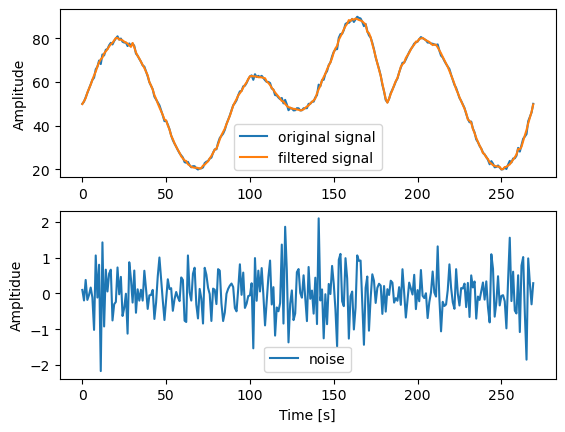

In [576]:
t = np.arange(0,N)
plt.subplot(2,1,1)
plt.plot(t,intr_y_coords, label = 'original signal')
plt.plot(t,out, label = 'filtered signal')
plt.ylabel('Amplitude')
# plt.xlim(0,250)
plt.legend()
plt.subplot(2,1,2)
plt.plot(t,noise, label = 'noise')
plt.legend()
# plt.xlim(0,250)
plt.xlabel('Time [s]')
plt.ylabel('Ampltidue')

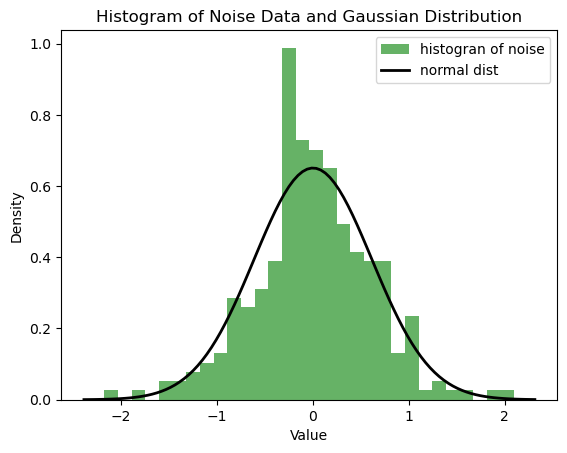

In [577]:
y_noise = noise

# Plot histogram of the data
plt.hist(y_noise, bins=30, density=True, alpha=0.6, color='g', label = 'histogran of noise')

# Plot Gaussian distribution curve for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(y_noise), np.std(y_noise))
plt.plot(x, p, 'k', linewidth=2, label = 'normal dist')
# plt.xlim(-15,15)
plt.legend()

plt.title("Histogram of Noise Data and Gaussian Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

## Filter 3 - Kalman

The Kalman filter is an algorithm used to estimate the state of a dynamic system from a series of noisy measurements [7]. It uses five equations which is iteritively computed to predict the next state, we will focus in this section on 1D static model, for filtering out unwanted noise in the position signal.

The equations can be summarised as the following [7],

1. State Update Equation

The estimate of the current state is updated using the equation:

$$
\hat{x}_{n, n} = \hat{x}_{n, n-1} + K_n(z_n - \hat{x}_{n, n-1})
$$

- $\hat{x}_{n, n}$: Updated estimate of the current state.
- $\hat{x}_{n, n-1}$: Predicted value of the current state.
- $K_n$: Kalman gain.
- $z_n$: Measurement at the current state.
- $z_n - \hat{x}_{n, n-1}$: Innovation or measurement residual.

2. Covariance Extrapolation Equation

The variance of the estimate $p$ is extrapolated to the next state using:

$$
p_{n+1,n} = p_{n,n}  + q_{n}
$$

- $p_{n+1,n}$: Extrapolated estimate variance.
- $p_{n,n}$: Current estimate variance.
- $q_n$: Process noise variance.

3. Kalman Gain Equation

The Kalman gain is computed as follows:

$$
K_n = \frac{p_{n, n-1}}{p_{n, n-1} + r_n}
$$

- $K_n$: Kalman gain.
- $p_{n, n-1}$: Extrapolated estimate variance.
- $r_n$: Measurement variance.

The Kalman gain determines how much weight should be given to the new measurement relative to the predicted estimate.

4. Covariance Update Equation

After updating the state estimate, the estimate variance is updated using:

$$
p_{n, n} = (1 - K_n) p_{n, n-1}
$$

- $p_{n, n}$: Updated estimate variance.

5. State Extrapolation Equation

For constant dynamics, the predicted value of the next state is simply the current updated estimate:

$$
\hat{x}_{n+1, n} = \hat{x}_{n, n}
$$

- $\hat{x}_{n+1, n}$: Predicted value of the next state.

This algorithm is used below,

##### x-coordinates

In [658]:
df = pd.read_csv(csv_file_path)
x_coords = df['x_coord']
y_coords = df['y_coord']
sigma_r = np.std(x_coords)
# Define the values
x_true = pca_xfiltered # True values
z = x_coords              # Measured values
N = len(z)

# Convert the standard deviation to variance
r = sigma_r**2
# p = 100

# Initialize the arrays
x_est = np.zeros(N)      # x_{n,n}
x_pred = np.zeros(N)     # x_{n,n-1}
p_est = np.zeros(N)      # p_{n,n}
p_pred = np.zeros(N)     # p_{n,n-1}
K = np.zeros(N)
q = 200   #50                

# Initial values
x_est[0] = z[0]
p_est[0] = z[0]
x_pred[0] = x_est[0] 
p_pred[0] = p_est[0] + q

Measurement variance $r$ was calculated, the process noise variable $q$ was initially chosen as 50 but later changed to improve accuracy (more on this below). Furthermore, initial values was provided for all arrays relative to the equations provided and initail values of the measured values. Although we do not know what the real true values are, the PCA results was chosen as the 'true' results for comparison.

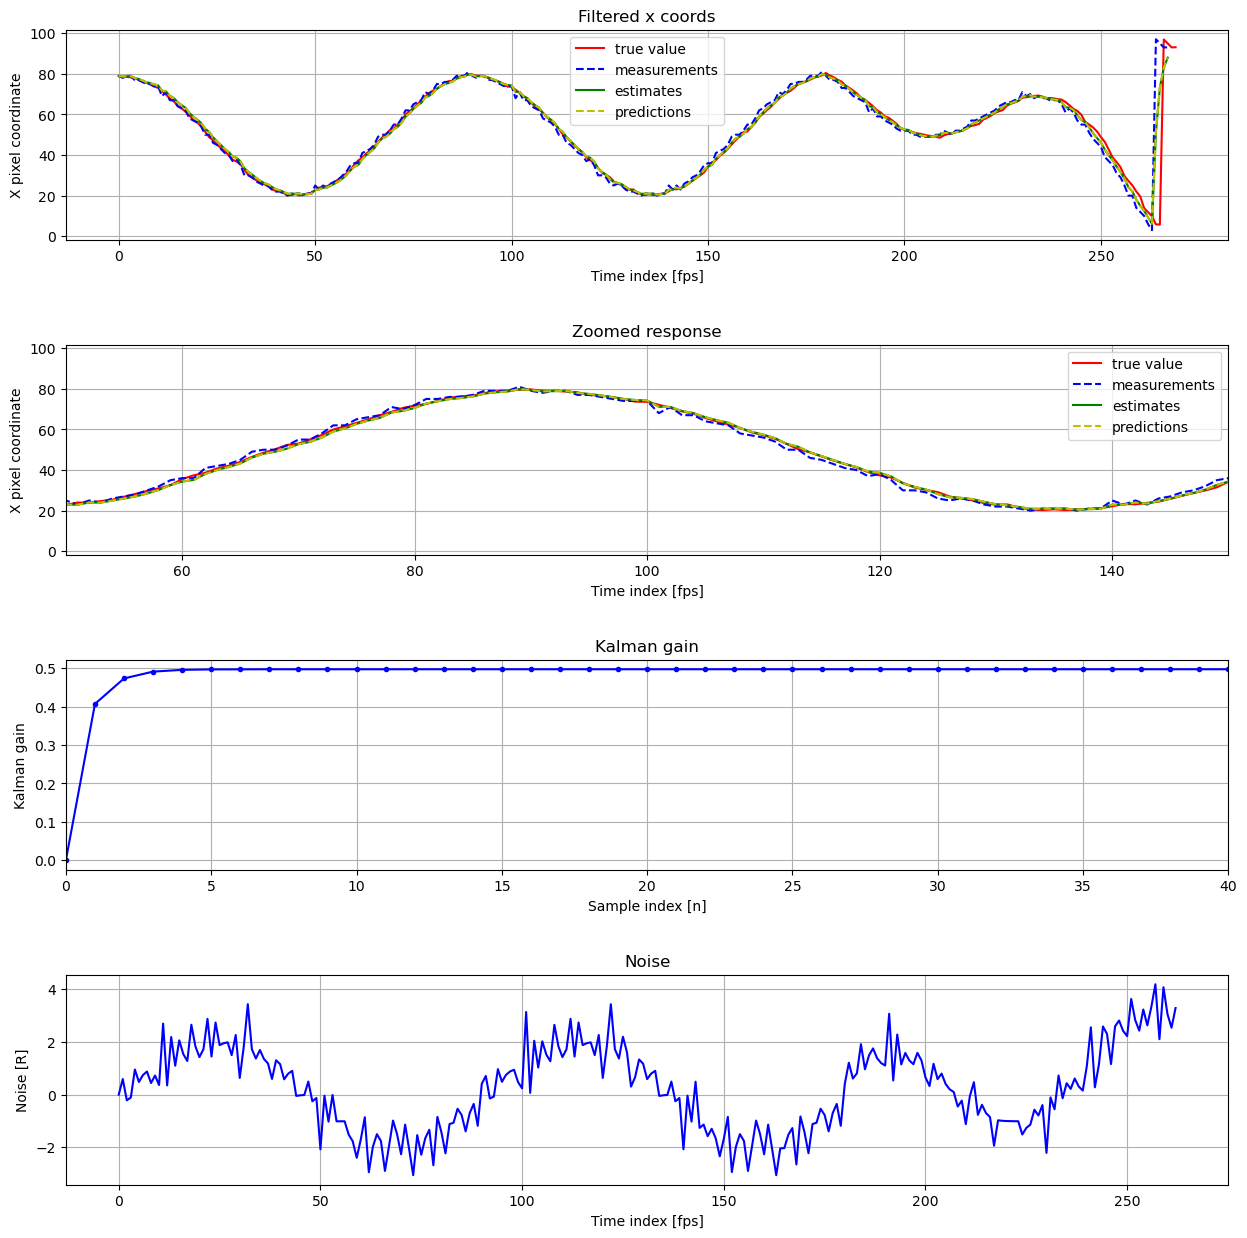

In [660]:
for n in range(1,N):
    K[n] = p_pred[n-1] / (p_pred[n-1] + r)                # Kalman Gain Equation
    x_est[n] = x_pred[n-1] + K[n]*(z[n] - x_pred[n-1])    # State Update Equation
    p_est[n] = (1 - K[n])*(p_pred[n-1])                   # Covariance Update Equation
    x_pred[n] = x_est[n]                                  # State Extrapolation Equation
    p_pred[n] = p_est[n] + q                              # Covariance Extrapolation Equation

noise = x_pred[:N-5] - x_coords[:N-5]
kalman_xnoise = noise
x_smoothed = x_pred
kalmanfilter_x = x_smoothed

indekse = np.arange(0,N)
t = np.arange(0,len(x_true))
plt.figure(figsize=(15, 15))
plt.subplot(4,1,1)
plt.plot(t,x_true,'r-',label='true value')
plt.plot(indekse,z,'b--',label='measurements')
plt.plot(indekse,x_est,'g-',label='estimates')
plt.plot(indekse,x_pred,'y--',label='predictions')
plt.title('Filtered x coords')
plt.xlabel('Time index [fps]')
plt.ylabel('X pixel coordinate')
plt.legend()
plt.subplots_adjust(hspace=0.5)
plt.grid()
plt.subplot(4,1,2)
plt.title('Zoomed response')
plt.plot(t,x_true,'r-',label='true value')
plt.plot(indekse,z,'b--',label='measurements')
plt.plot(indekse,x_est,'g-',label='estimates')
plt.plot(indekse,x_pred,'y--',label='predictions')
plt.legend()
plt.xlabel('Time index [fps]')
plt.ylabel('X pixel coordinate')
plt.xlim(50,150)
plt.grid()
plt.subplot(4,1,3)
plt.title('Kalman gain')
plt.plot(indekse,K,'b.-')
plt.xlabel('Sample index [n]')
plt.ylabel('Kalman gain')
plt.xlim(0,40)
plt.grid()
plt.subplot(4,1,4)
plt.title('Noise')
plt.plot(indekse[:N-5], noise,'b-')
plt.xlabel('Time index [fps]')
plt.ylabel('Noise [R]')
plt.grid()
plt.show()

Increasing the process noise q, decreases delay and error relative to the measurement results. Similarly, the noise was calculated and based on the guasisan plot, the process noise was adjusted accordingly. This parameter also increases time to which the Kalman gain reaches steady state and thus reaches maximum accuracy, which can also be seen in the comparison plot when compared to the measured results.

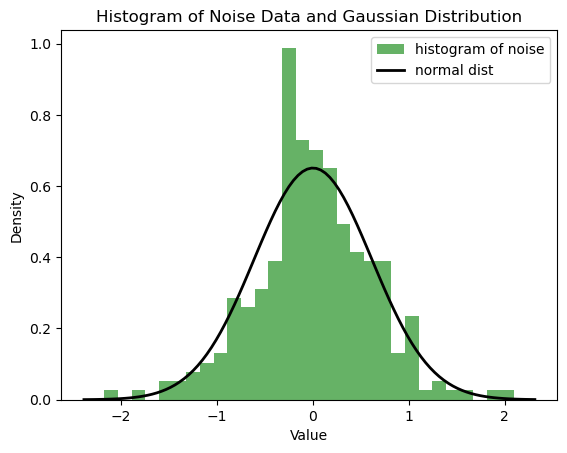

In [541]:
from scipy.stats import norm
x_noise = noise

# Plot histogram of the data
plt.hist(x_noise, bins=30, density=True, alpha=0.6, color='g', label = 'histogram of noise')

# Plot Gaussian distribution curve for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(x_noise), np.std(x_noise))
plt.plot(x, p, 'k', linewidth=2, label = 'normal dist')
# plt.xlim(-15,15)
plt.legend()

plt.title("Histogram of Noise Data and Gaussian Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

We can confirm that the noise that has been filtered out, has a gaussian dist. Although the noise can be seen to have a seasonal component, which indicates that some of the underlying trend is removed, the results was good enough, with a removal of maximum of 1 pixel, thus it was decided to not change the filter. Still a lot of the 'estimated noise' is truely measurement noise, when analysing its distribution. 

From the Kalman gain plot, it can be seen that the gain does converge quite quickly, which emphasises the algorithms confidence in its prediction. From the zoomed response it can be noted that the prediction as well as estimation results are very close to the "true" PCA results. It can also be noted that the prediciton and estimation results are identical, which is due to the constant dynamics in this model's approach, and is further motivated when observing the State Extrapolation Equation.

Additionally, absolute and relative errors can be calculated between the prediction and estimated results to the "true" PCA results, to analyse the precision in the filters' results. Take note that the slight phase shift was due to the interpolation done to the pca signal in the previous section.

In [590]:
# Calculate absolute and relative errors
true_values = pca_xfiltered[100:150]
pred_values = x_pred[100:150]
est_values = x_est[100:150]
abs_errors_pred = np.abs(true_values - pred_values)
abs_errors_est = np.abs(true_values - est_values)

rel_errors_pred = (abs_errors_pred / true_values) * 100
rel_errors_est = (abs_errors_est / true_values) * 100

# Print average absolute and relative errors
print("Average Absolute Error (Predictions):", round(np.mean(abs_errors_pred),2), "pixels")
print("Average Relative Error (Predictions):", round(np.mean(rel_errors_pred),2), "%")
print("Average Absolute Error (Estimates):", round(np.mean(abs_errors_est),2), "pixels")
print("Average Relative Error (Estimates):", round(np.mean(rel_errors_est),2), "%")

Average Absolute Error (Predictions): 0.42 pixels
Average Relative Error (Predictions): 1.31 %
Average Absolute Error (Estimates): 0.42 pixels
Average Relative Error (Estimates): 1.31 %


Again we are satisfied with this filter's response with a absolute and relative error to the PCA results of less than 1 pixel, which emphasises the precision in our filters' accuracy. 

##### y-coordinates

Again, the procedure is repeated for the y-coordinates signal, this time we can observe the great performance of the Kalman filter even for sharp transitions, while still maintaining excellent accuracy in its predictions.

In [661]:
df = pd.read_csv(csv_file_path)
x_coords = df['x_coord']
y_coords = df['y_coord']
sigma_r = np.std(y_coords)
# Define the values
x_true = pca_yfiltered # True values
z = y_coords              # Measured values
N = len(z)

# Convert the standard deviation to variance
r = sigma_r**2
# p = 100

# Initialize the arrays
x_est = np.zeros(N)      # x_{n,n}
x_pred = np.zeros(N)     # x_{n,n-1}
p_est = np.zeros(N)      # p_{n,n}
p_pred = np.zeros(N)     # p_{n,n-1}
K = np.zeros(N)
q = 200   #50                

# Initial values
x_est[0] = z[0]
p_est[0] = z[0]
x_pred[0] = x_est[0] 
p_pred[0] = p_est[0] + q

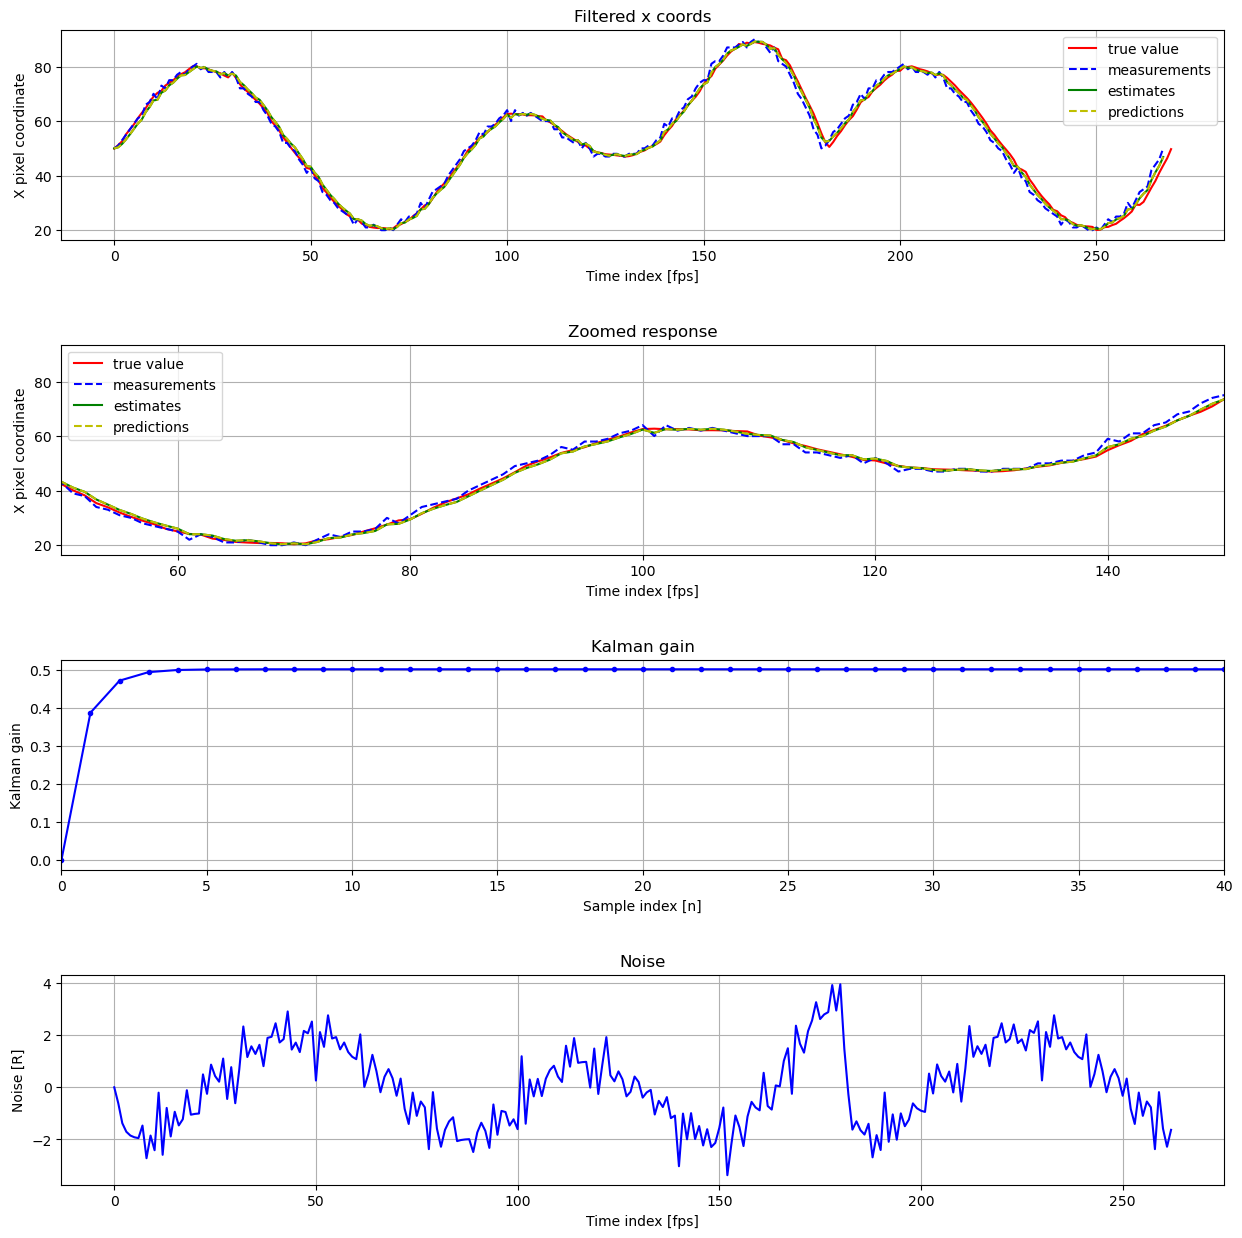

In [666]:
for n in range(1,N):
    K[n] = p_pred[n-1] / (p_pred[n-1] + r)                # Kalman Gain Equation
    x_est[n] = x_pred[n-1] + K[n]*(z[n] - x_pred[n-1])    # State Update Equation
    p_est[n] = (1 - K[n])*(p_pred[n-1])                   # Covariance Update Equation
    x_pred[n] = x_est[n]                                  # State Extrapolation Equation
    p_pred[n] = p_est[n] + q                              # Covariance Extrapolation Equation

noise = x_pred[:N-5] - y_coords[:N-5]
kalman_ynoise = noise
y_smoothed = x_pred
kalmanfilter_y = y_smoothed

indekse = np.arange(0,N)
t = np.arange(0,len(x_true))
plt.figure(figsize=(15, 15))
plt.subplot(4,1,1)
plt.plot(t,x_true,'r-',label='true value')
plt.plot(indekse,z,'b--',label='measurements')
plt.plot(indekse,x_est,'g-',label='estimates')
plt.plot(indekse,x_pred,'y--',label='predictions')
plt.title('Filtered x coords')
plt.xlabel('Time index [fps]')
plt.ylabel('X pixel coordinate')
plt.legend()
plt.subplots_adjust(hspace=0.5)
plt.grid()
plt.subplot(4,1,2)
plt.title('Zoomed response')
plt.plot(t,x_true,'r-',label='true value')
plt.plot(indekse,z,'b--',label='measurements')
plt.plot(indekse,x_est,'g-',label='estimates')
plt.plot(indekse,x_pred,'y--',label='predictions')
plt.legend()
plt.xlabel('Time index [fps]')
plt.ylabel('X pixel coordinate')
plt.xlim(50,150)
plt.grid()
plt.subplot(4,1,3)
plt.title('Kalman gain')
plt.plot(indekse,K,'b.-')
plt.xlabel('Sample index [n]')
plt.ylabel('Kalman gain')
plt.xlim(0,40)
plt.grid()
plt.subplot(4,1,4)
plt.title('Noise')
plt.plot(indekse[:N-5], noise,'b-')
plt.xlabel('Time index [fps]')
plt.ylabel('Noise [R]')
plt.grid()
plt.show()

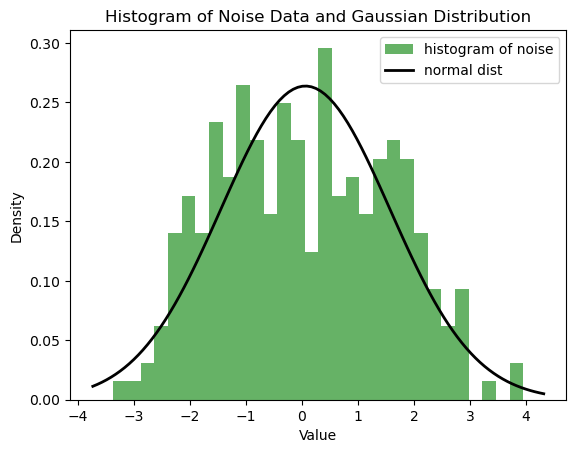

In [594]:
y_noise = noise

# Plot histogram of the data
plt.hist(y_noise, bins=30, density=True, alpha=0.6, color='g', label = 'histogram of noise')

# Plot Gaussian distribution curve for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(y_noise), np.std(y_noise))
plt.plot(x, p, 'k', linewidth=2, label = 'normal dist')
# plt.xlim(-15,15)
plt.legend()

plt.title("Histogram of Noise Data and Gaussian Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

In [595]:
# Calculate absolute and relative errors
true_values = pca_yfiltered[100:150]
pred_values = x_pred[100:150]
est_values = x_est[100:150]
abs_errors_pred = np.abs(true_values - pred_values)
abs_errors_est = np.abs(true_values - est_values)

rel_errors_pred = (abs_errors_pred / true_values) * 100
rel_errors_est = (abs_errors_est / true_values) * 100

# Print average absolute and relative errors
print("Average Absolute Error (Predictions):", round(np.mean(abs_errors_pred),2), "pixels")
print("Average Relative Error (Predictions):", round(np.mean(rel_errors_pred),2), "%")
print("Average Absolute Error (Estimates):", round(np.mean(abs_errors_est),2), "pixels")
print("Average Relative Error (Estimates):", round(np.mean(rel_errors_est),2), "%")

Average Absolute Error (Predictions): 0.38 pixels
Average Relative Error (Predictions): 0.67 %
Average Absolute Error (Estimates): 0.38 pixels
Average Relative Error (Estimates): 0.67 %


Same conslusions as with the x-coordinates.

## Filter 4 - Wiener

A Wiener filter is a digital filter that has self-adjusting characteristics, also known as an adapter filter. It is capable of adjusting its filter coefficients automatically to adapt the input signal via an adaptive algorithm. Our algorithm uses an adaptive finite impulse response (FIR) filter with a simple and popular least mean square (LMS) algorithm. 

The LMS algorithm iteratively adjusts the filter or predictor coefficients to minimize the error between the desired signal and the filter output. By minimize the Mean Square Error (MSE) on every sample, it can determine the optimal filter coefficient(s) [9].

The Wiener filter using the LMS algorithm in summarised as the following [9]:
1. Initialize $w(0), w(1), \ldots, w(N-1)$ to arbitrary values.
2. Read $d(n), x(n)$, and perform digital filtering:
$$
y(n)=w(0) x(n)+w(1) x(n-1)+\cdots+w(N-1) x(n-N+1) \text {. }
$$
3. Compute the output error:
$$
e(n)=d(n)-y(n)
$$
4. Update each filter coefficient using the LMS algorithm:
$$
\begin{aligned}
\text { for } i & =0, \ldots, N-1 \\
w(i) & =w(i)+2 \mu e(n) x(n-i) .
\end{aligned}
$$

##### x-coordinates

1. Architecture using noise

The first architecture estimates the noise and subtracting it to the contaminated signal to produce an error that should represent the clean signal. The noise from the Kalman filter was used  as reference.

In [602]:
# Create a random number generator
rng = np.random.default_rng() 
N = len(x_coords)                   # number of samples

# Calculate the standard deviation of z_sucdiff
sd = np.std(kalman_xnoise)
print('Standard deviation of predicted noise: ',sd)
pred_noise = rng.normal(0,sd,N)  #original size
x = pred_noise

Standard deviation of predicted noise:  1.5918021010994825


Step 1: Assign rbitrary weights, and choose filter order of 1. Furthermore, $\mu_{max}$ is calculated and $\mu$ is chosen arbirarity smaller than it. Ideally we change $\mu$ to let the filter weigths converge to some value, while keeping the output results stable.

In [617]:
Nfilter = 3  #2 #1                       # Filter order                  
w_record = np.zeros((N,Nfilter))
y = np.zeros(N)                     # FIR filter output
error = np.zeros(N)
mu_max = 1/(np.std(pred_noise)*Nfilter)
print('Maximum step-size: ',mu_max)
# Choose mu such that filter weights converge
mu = 0.0005

Maximum step-size:  0.1963956253495466


Step 2: Implement the FIR filter, calculate the error and update the weights according to LMS as mentioned above.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


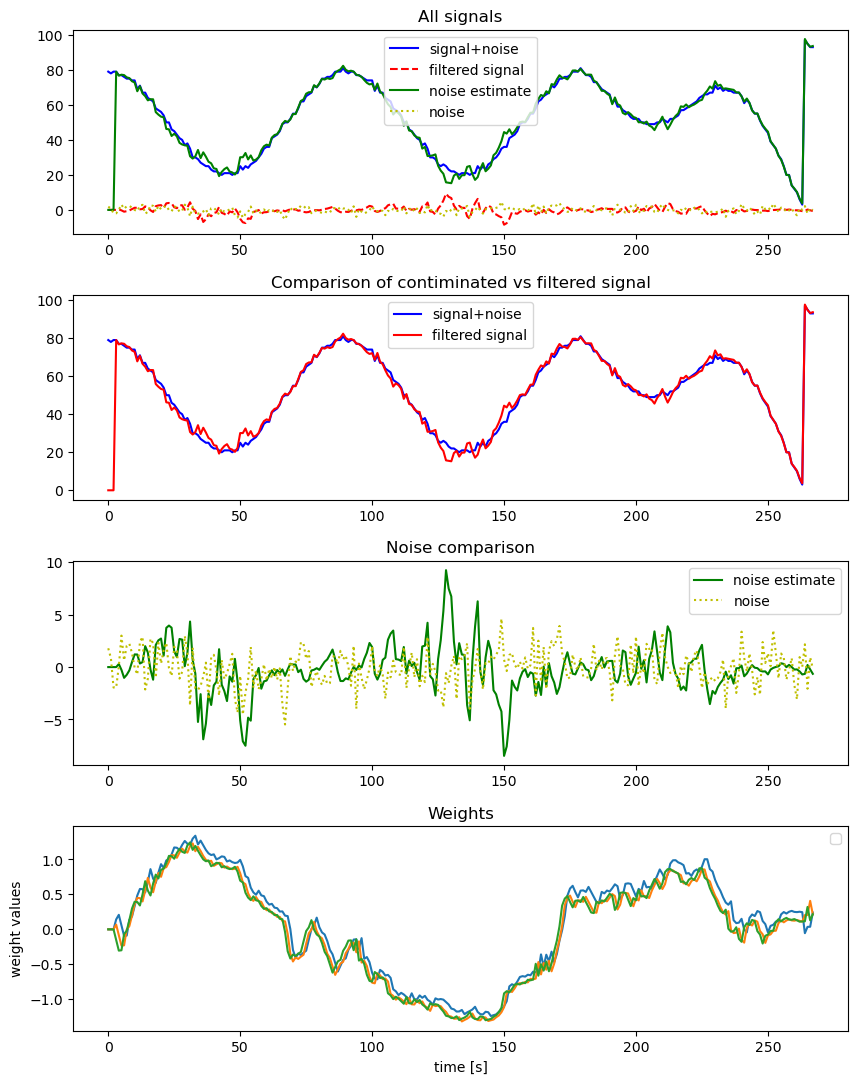

True Noise std: 1.697254369795986
Estimated Noise std: 2.200611473422145


In [618]:
d = x_coords

for k in range(Nfilter, N):
    y[k] = np.sum(w_record[k-1,:]*x[k-Nfilter:k])
    error[k] = d[k] - y[k]
    w_record[k,:] = w_record[k-1,:] + 2*mu*error[k]*x[k-Nfilter:k]

t = np.arange(0,N)

# Plot the results
plt.figure(figsize=(10, 13))
plt.subplot(4,1,1)
plt.title('All signals')
plt.plot(t,d,'b',label='signal+noise')
plt.plot(t,y,'r--',label='filtered signal')
plt.plot(t,error,'g',label='noise estimate')
plt.plot(t,pred_noise,'y:',label='noise')
plt.legend()
plt.subplots_adjust(hspace=0.3)
plt.subplot(4,1,2)
plt.title('Comparison of contiminated vs filtered signal')
plt.plot(t,d,'b',label='signal+noise')
plt.plot(t,error,'r',label='filtered signal')
plt.legend()
plt.subplots_adjust(hspace=0.3)
plt.subplot(4,1,3)
plt.title('Noise comparison')
plt.plot(t,y,'g',label='noise estimate')
plt.plot(t,pred_noise,'y:',label='noise')
plt.legend()
plt.subplots_adjust(hspace=0.3)
plt.subplot(4,1,4)
plt.title('Weights')
plt.plot(t,w_record)
plt.ylabel('weight values')
plt.xlabel('time [s]')
plt.legend()
plt.show()

print('True Noise std:', np.std(x))
print('Estimated Noise std:', np.std(y))

Even after the fillter order was increased to higher orders and $\mu$ decreased, to allow the filter weights to converge and try to obtain a better approximation of the 'true' noise, the results was very bad. $\mu$ was also adjusted to ensure estimation of noise close to the desired by observing the standard deviation and the visual plots of both the 'true' and estimated noise above.

We can conclude it is very hard to model, someting that is unpredictable, this is further motivated in the variation of the filter weigths, which shows the lack of confidence in the LMS algorithm. 

A better approach would be to model the predictable part of the noisy signal with an adaptive FIR filter. Thus, we can make use of another architecture which predicts the underlying clean signal, and the error relative to the contaminated signal provides us with the noise. T

2. Architecture to model filtered signal.

Step 1: Assign arbitrary weights, and choose filter order of 1. Furthermore, $\mu_{max}$ is calculated and $\mu$ is chosen arbirarity smaller than it. Ideally we change $\mu$ to a smaller value to let the filter weigths converge to some value, while keeping the output results stable.

In [633]:
Nfilter = 3  #2 #1                       # Filter order                  
w_record = np.zeros((N,Nfilter))
y = np.zeros(N)                     # FIR filter output
error = np.zeros(N)
mu_max = 1/(np.std(pred_noise)*Nfilter)
print('Maximum step-size: ',mu_max)
# Choose mu such that filter weights converge
mu = 0.00001

Maximum step-size:  0.1963956253495466


Step 2: Implement the FIR filter, calculate the error and update the weights according to LMS as mentioned above.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


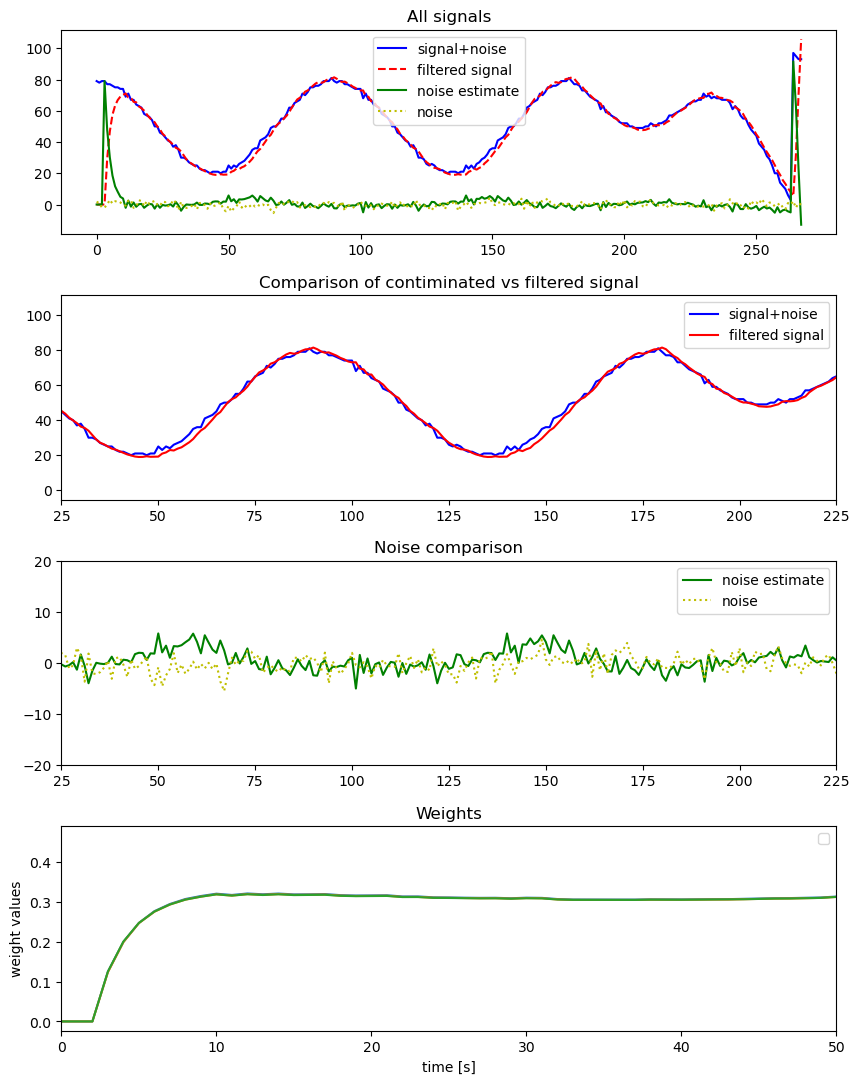

True Noise: 1.7
Estimatd Noise: 1.99
RMS error: 2.69


In [646]:
d = x_coords

for k in range(Nfilter, N):
    y[k] = np.sum(w_record[k-1,:]*d[k-Nfilter:k])  #first window (k-Nfilter) is mutiplied by 0
    error[k] = d[k] - y[k]
    w_record[k,:] = w_record[k-1,:] + 2*mu*error[k]*d[k-Nfilter:k] #too small mu values eliminates second term and weights are not adjusted according to error

t = np.arange(0,N)

# Plot the results
plt.figure(figsize=(10, 13))
plt.subplot(4,1,1)
plt.title('All signals')
plt.plot(t,d,'b',label='signal+noise')
plt.plot(t,y,'r--',label='filtered signal')
plt.plot(t,error,'g',label='noise estimate')
plt.plot(t,pred_noise,'y:',label='noise')
plt.legend()
plt.subplots_adjust(hspace=0.3)
plt.subplot(4,1,2)
plt.title('Comparison of contiminated vs filtered signal')
plt.plot(t,d,'b',label='signal+noise')
plt.plot(t,y,'r',label='filtered signal')
plt.xlim(25,225)
plt.legend()
plt.subplots_adjust(hspace=0.3)
plt.subplot(4,1,3)
plt.title('Noise comparison')
plt.plot(t,error,'g',label='noise estimate')
plt.plot(t,pred_noise,'y:',label='noise')
plt.legend()
plt.xlim(25,225)
plt.ylim(-20,20)
plt.subplots_adjust(hspace=0.3)
plt.subplot(4,1,4)
plt.title('Weights')
plt.plot(t,w_record)
plt.ylabel('weight values')
plt.xlabel('time [s]')
plt.legend()
plt.xlim(0,50)
plt.show()

print('True Noise:', round(np.std(x),2))
print('Estimatd Noise:', round(np.std(error[25:225]),2))
print('RMS error:', round(np.sqrt(np.mean((x[25:225]-error[25:225])**2)),2))

Take note that the first window length of the contaminated signal is multiplied by zero, as no weights are assigned to the filter yet, thus the prediction, and consequently the error, is also zero. The RMS error was calculated for a range where the LMS weights are settled.

Design decisions and alternative results,

Order of 3 with a very small $\mu$ value of 0.00001 was chosen, to converge the weigths and produce an accurate representation of the 'clean' signal. These values were obatined by minimising the RMS and standard deviation error between the estimated noise and 'true' noise, as shown from the calculations above. Furthermore, although order 2 provided smaller RMS error, the 'clean' signal still contained some noise, by observing the plot.

Initial order 1 introduced too much noise, and order 2's weights still takes long to converge, thus higher orders was needed. Order 3 was chosen to minimise converging time, while eliminating most noise. Higher order FIR filters will introduce too much initial delay, beacuse of the number of weights increasing in proportion to the filter order. Moreover, $\mu$ was made smaller untill the weights converge to some value, it was noted that too small $\mu$, causes unstability in the output response of the filter, oscillating to very high values, due to one of the LMS algorithm's terms being almost eliminated.

Finally, we have confirmed the standard devistion is very close to the 'true' noise, now again confirming that the noise extracted has a normal distribution.

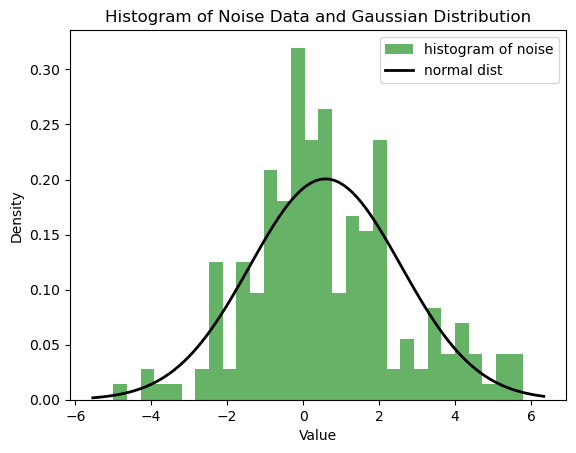

In [647]:
from scipy.stats import norm
x_noise = error[25:225]  #excluding start and end

# Plot histogram of the data
plt.hist(x_noise, bins=30, density=True, alpha=0.6, color='g', label = 'histogram of noise')

# Plot Gaussian distribution curve for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(x_noise), np.std(x_noise))
plt.plot(x, p, 'k', linewidth=2, label = 'normal dist')
# plt.xlim(-15,15)
plt.legend()

plt.title("Histogram of Noise Data and Gaussian Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

Finally, it can be confirmed that the noise is normally distributed, and the Wiener filter produced a filtered signal that is sufficient for this practical, providing very small error relative to the Kalman filter's output, again showing the presicion in the filters' outputs.

##### y-coordinates

The same procedure will be followed with the y-coordinates signal, but only using the second architecture as above, estimating the clean signal and using the error as our noise approximation.

In [651]:
Nfilter = 3  #2 #1                       # Filter order                  
w_record = np.zeros((N,Nfilter))
y = np.zeros(N)                     # FIR filter output
error = np.zeros(N)
mu_max = 1/(np.std(pred_noise)*Nfilter)
print('Maximum step-size: ',mu_max)
# Choose mu such that filter weights converge
mu = 0.00001

Maximum step-size:  0.1963956253495466


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


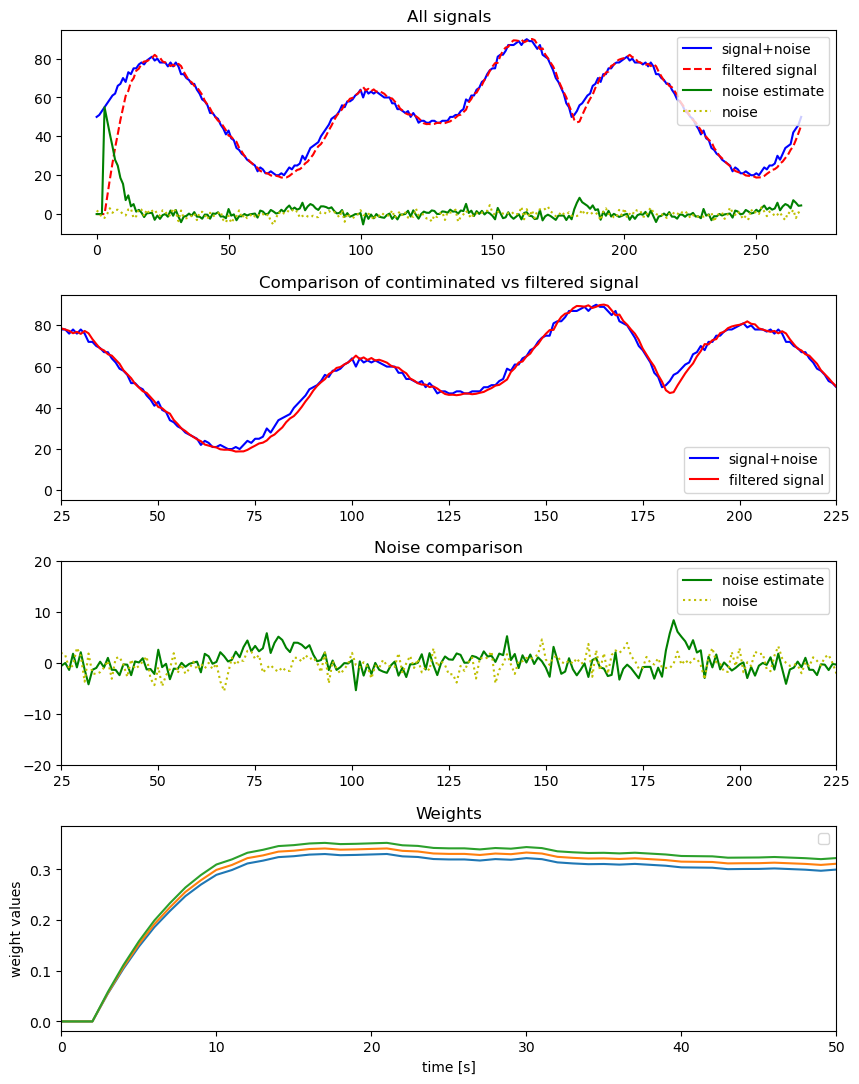

True Noise: 4.4
Estimatd Noise: 2.11
RMS error: 2.68 pixels


In [653]:
d = y_coords

for k in range(Nfilter, N):
    y[k] = np.sum(w_record[k-1,:]*d[k-Nfilter:k])  #first window (k-Nfilter) is mutiplied by 0
    error[k] = d[k] - y[k]
    w_record[k,:] = w_record[k-1,:] + 2*mu*error[k]*d[k-Nfilter:k] #too small mu values eliminates second term and weights are not adjusted according to error

t = np.arange(0,N)

# Plot the results
plt.figure(figsize=(10, 13))
plt.subplot(4,1,1)
plt.title('All signals')
plt.plot(t,d,'b',label='signal+noise')
plt.plot(t,y,'r--',label='filtered signal')
plt.plot(t,error,'g',label='noise estimate')
plt.plot(t,pred_noise,'y:',label='noise')
plt.legend()
plt.subplots_adjust(hspace=0.3)
plt.subplot(4,1,2)
plt.title('Comparison of contiminated vs filtered signal')
plt.plot(t,d,'b',label='signal+noise')
plt.plot(t,y,'r',label='filtered signal')
plt.xlim(25,225)
plt.legend()
plt.subplots_adjust(hspace=0.3)
plt.subplot(4,1,3)
plt.title('Noise comparison')
plt.plot(t,error,'g',label='noise estimate')
plt.plot(t,pred_noise,'y:',label='noise')
plt.legend()
plt.xlim(25,225)
plt.ylim(-20,20)
plt.subplots_adjust(hspace=0.3)
plt.subplot(4,1,4)
plt.title('Weights')
plt.plot(t,w_record)
plt.ylabel('weight values')
plt.xlabel('time [s]')
plt.legend()
plt.xlim(0,50)
plt.show()

print('True Noise:', round(np.std(x),2))
print('Estimatd Noise:', round(np.std(error[25:225]),2))
print('RMS error:', round(np.sqrt(np.mean((pred_noise[25:225]-error[25:225])**2)),2), 'pixels')

The same values as with the x-coordinates seemed to provide the best results, although again this algorithm struggles with sharp transistions, as seen from the second zoomed in plot. An order increase or smaller $\mu$ did not improve the overall results. Although this results is still within the practical specifications as the RMS error and error relative to the 'true' noise is still very small.

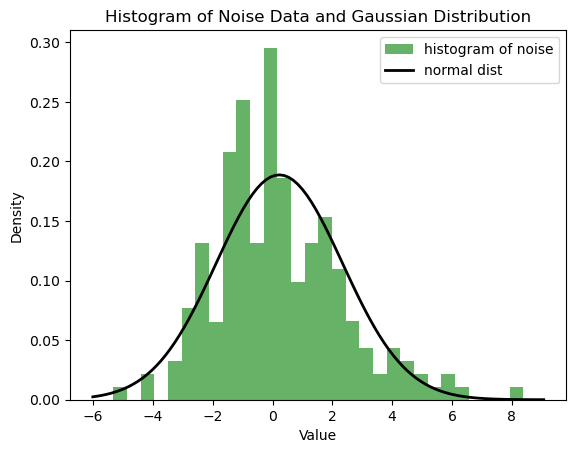

In [654]:
x_noise = error[25:225]  #excluding start and end

# Plot histogram of the data
plt.hist(x_noise, bins=30, density=True, alpha=0.6, color='g', label = 'histogram of noise')

# Plot Gaussian distribution curve for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(x_noise), np.std(x_noise))
plt.plot(x, p, 'k', linewidth=2, label = 'normal dist')
# plt.xlim(-15,15)
plt.legend()

plt.title("Histogram of Noise Data and Gaussian Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

Same conclusion as with the x-coordinates.

# Part 3 - Prediction

A filtered signal will be used for prediction model traning, this will allow more confidence in model prediction, without a lot of noise causing unnessasary error increase. Furthermore, these smooth responses will allow more accurate predictions in terms of minimising the overall prediction error, and estimating a continuous signal over the current discrete results.

The kalman filter's results is chosen for prediction. This filter's response provided better results for fast transitions, and has no delay or inital transistion, but rather instantaneous high accuracy prediction throughout the entire signals. Lastly, it contains the original length, and was not interpolated as with PCA.

## Prediction 1 - Kalman

Two 1D Kalman filters will be used for prediction for both the x and y coordinates. The 2D approach will not provide a very accurate representation, as the UFO travels over its original position and thus will be harder to analyse the results over time.

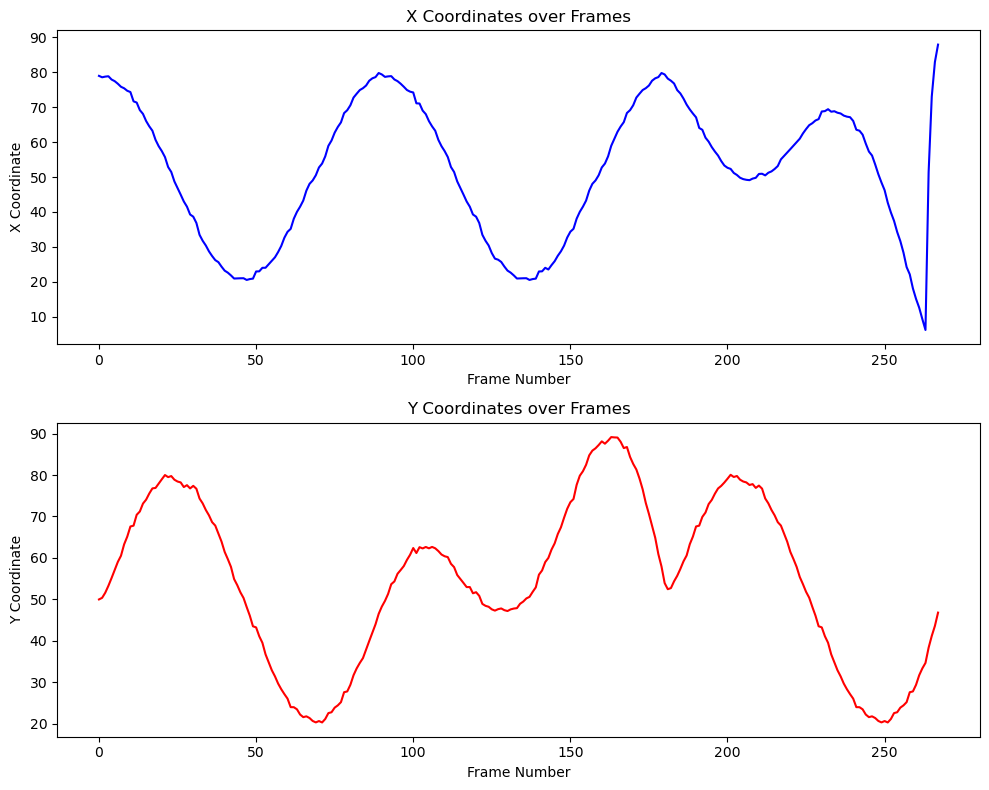

In [668]:
x_signal = kalmanfilter_x
y_signal = kalmanfilter_y

t = np.arange(0,len(x_signal))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the x-coordinates against frame numbers
ax1.plot(t, x_signal, 'b')
ax1.set_title('X Coordinates over Frames')
ax1.set_xlabel('Frame Number')
ax1.set_ylabel('X Coordinate')

# Plot the y-coordinates against frame numbers
ax2.plot(t, y_signal, 'r')
ax2.set_title('Y Coordinates over Frames')
ax2.set_xlabel('Frame Number')
ax2.set_ylabel('Y Coordinate')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

A multidimentional dynamic Newton model is chosen, as newtonian mechanics will model movement such as acceleration and velocity better than the traditional static model as used for filtering. The new update equations are given below,


1. **State Prediction Equations**

The predicted state and its covariance are given by:

$$
\hat{x}_{n|n-1} = F \hat{x}_{n-1|n-1}
$$

$$
P_{n|n-1} = F P_{n-1|n-1} F^T + Q
$$

- \(\hat{x}_{n|n-1}\): Predicted state estimate at time \( n \).
- \( F \): State transition matrix.
- \( P_{n|n-1}\): Predicted estimate covariance matrix.
- \( P_{n-1|n-1}\): Previous estimate covariance matrix.
- \( Q \): Process noise covariance matrix.

2. **Measurement Update Equations**

After obtaining a new measurement \( z_n \), the state estimate and covariance are updated using:

3. **Kalman Gain Equation**

$$
K_n = P_{n|n-1} H^T (H P_{n|n-1} H^T + R)^{-1}
$$

- \( K_n \): Kalman gain matrix.
- \( H \): Measurement matrix.
- \( R \): Measurement noise covariance matrix.

4. **State Update Equation**

$$
\hat{x}_{n|n} = \hat{x}_{n|n-1} + K_n (z_n - H \hat{x}_{n|n-1})
$$

- \(\hat{x}_{n|n}\): Updated state estimate at time \( n \).
- \( z_n \): Measurement at time \( n \).

5. **Covariance Update Equation**

$$
P_{n|n} = (I - K_n H) P_{n|n-1}
$$

- \( P_{n|n}\): Updated estimate covariance matrix.
- \( I \): Identity matrix.

The model was gathered from [8], and is summarise as follows,

The **process noise covariance matrix $Q$** is given by:

$$
Q = \left[ \begin{array}{cc}
\frac{\Delta t^4}{4} & \frac{\Delta t^3}{2} \\
\frac{\Delta t^3}{2} & \Delta t^2
\end{array} \right] \sigma_{\ddot{x}}^2
$$

where:
- $ \Delta t $ is the time step (which is chosen at 1).
- $ \sigma_{\ddot{x}}^2 $ is the variance of the acceleration noise (which is equal to 1).

The **measurement noise covariance matrix $R$** is given by:

$$
R = \sigma_{y}^2
$$

where:
- $ \sigma_{y} $ is the variance of the measurement noise.

The **state transition matrix $F$** is given by:

$$
F = \begin{bmatrix}
1 & \Delta t \\
0 & 1
\end{bmatrix}
$$


The **control input matrix $B$** is given by:

$$
B = \begin{bmatrix}
\frac{1}{2} (\Delta t)^2 \\
\Delta t
\end{bmatrix}
$$

but we will not be using it.

Assuming we can directly observe the position $_t$ and velocity $\dot{x}_t$, the **observation matrix $H$** is:

$$
H = \begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

**Step 1: Get training and testing data**

We will use half the data for training, to determine the converged Kalman gain, and use this to test the model on the second half of the data.

In [667]:
num_frames = 270

N_train = int(num_frames / 2)
print(f"N_train: {N_train} frames, and N_test: {num_frames-N_train} frames.")
z_train = x_signal[0:N_train]
z_test = y_signal[N_train:]

N_train: 135 frames, and N_test: 135 frames.


**Step 2: calculate the standard deviation of position, velocity and acceleration**

The measuremnt noise $\sigma_{y}$ was calculated form the noise extracted from Part 2, and the standard deviation calculated accodingly. Similarly, the standrad deviation of position, velocity and acceleration was also gathered from [8], and calculated below.

In [700]:
N = N_train

deltaT = 1   #arbitrarily chosen
sigma_z = np.std(z_train)
sigma_a = (sigma_z*2)/(deltaT**2)
sigma_v = sigma_a * deltaT
sigma_y = np.std(pred_noise) 

z = z_train

**Step 3: obtain a state-equation model for the system**

Using the equations as gather from [8] and summurised above, we can calulate matrices F and H. Take note the observation matrix H was reshaped to [1 0] to be able to use with our 1D signals.

In [701]:
Nx = 2                      # dimension of state-vector
Nz = 1                      # number of measured variables
x_est = np.zeros((Nx,N))
F = np.array([(1,deltaT),
              (0,1)])
print('F matrix:')
print('---------')
print(F)
H = np.array([1, 0])

# Reshape the array to have shape (1, 2)
H = H.reshape(1, 2) #Same as C matrix
print('H matrix:')
print('---------')
print(H)

F matrix:
---------
[[1 1]
 [0 1]]
H matrix:
---------
[[1 0]]


Matrices P, Q and R are also calculated from the equations above. Take note that the initial value for the P matrix was chosen based on trial and error, when observing the accuracy of the fit on the plot.

In [702]:
P = np.eye(Nx) * 200 #50
Q = np.array([((deltaT**4)/4,(deltaT**3)/2),
              ((deltaT**3)/2,deltaT**2)])
Q = Q * (sigma_a**2)
R = np.eye(Nz) * (sigma_y**2)

print('P matrix:')
print('---------')
print(P)
print('Q matrix:')
print('---------')
print(Q)
print('R matrix:')
print('---------')
print(R)

P matrix:
---------
[[200.   0.]
 [  0. 200.]]
Q matrix:
---------
[[ 422.2410775   844.48215501]
 [ 844.48215501 1688.96431002]]
R matrix:
---------
[[2.8806724]]


### x-coordinates

#### fit model

(2, 1, 135)


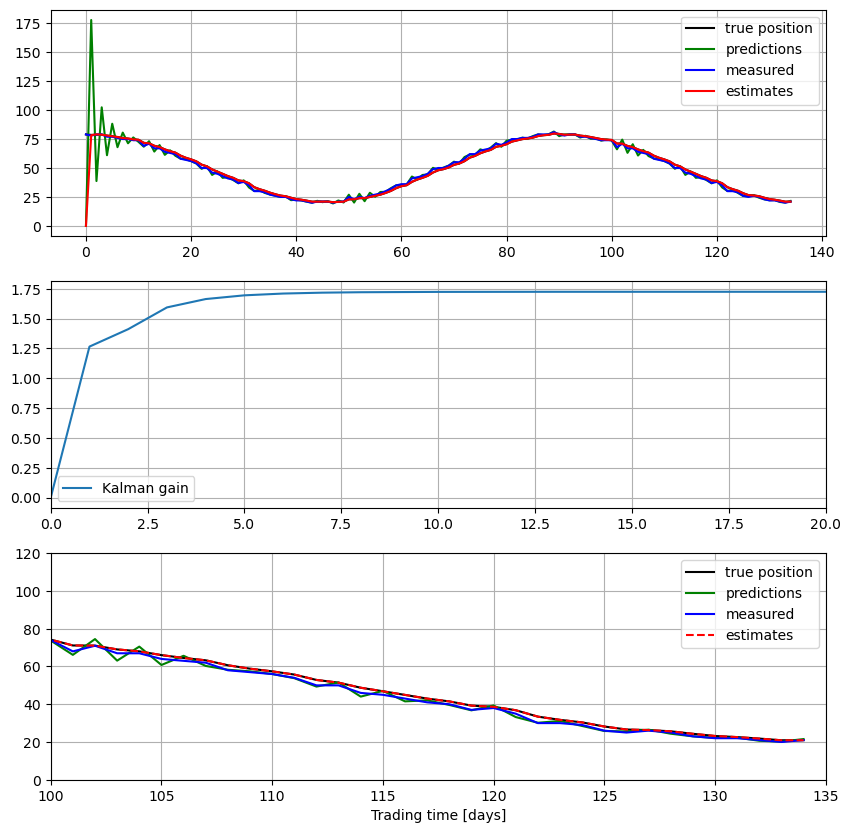

P_est : [[  2.86604968   4.96963222]
 [  4.96963222 129.56489844]]


In [704]:
N = N_train
z = z_train
P_est = P
P_pred = F @ P_est @ F.T + Q
# print(P_pred.shape)
x_pred = np.zeros((Nx,N))
K = np.zeros((Nx,Nz,N))
# K = np.zeros((2,N))
I = np.eye(Nx)
for n in range(1,N):
    K[:,:,n] = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
    x_est[:,n] = x_pred[:,n-1] + K[:,:,n]@(z[n] - H @ x_pred[:,n-1])
    P_est = (I-K[:,:,n]@H) @ P_pred @ (I - K[:,:,n] @ H).T + (K[:,:,n] @ R @ K[:,:,n].T)
    x_pred[:,n] = F @ x_est[:,n]
    P_pred = F @ P_est @ F.T + Q



print(K.shape)

indekse = np.arange(0,N)
plt.figure(figsize=(10, 10))
plt.subplot(3,1,1)
plt.plot(indekse,z,'k-',label='true position')
plt.plot(indekse,x_pred[0,:],'g-',label='predictions')
plt.plot(indekse,x_coords[0:N_train],'b-',label='measured')
plt.plot(indekse,x_est[0,:],'r-',label='estimates')
plt.grid('true')
plt.legend()
plt.subplot(3,1,2)
plt.plot(indekse,K[1,0,:], label = 'Kalman gain')
plt.xlim(0,20)
# plt.ylim(1.5,2)
plt.legend()
plt.grid('true')
plt.subplot(3,1,3)
plt.plot(indekse,z,'k-',label='true position')
plt.plot(indekse,x_pred[0,:],'g-',label='predictions')
plt.plot(indekse,x_coords[0:N_train],'b-',label='measured')
plt.plot(indekse,x_est[0,:],'r--',label='estimates')
plt.xlim(100,N)
plt.ylim(0,120)
plt.legend()
plt.grid('true')
plt.xlabel('Trading time [days]')
plt.show()

print(f"P_est : {P_est}")

In [705]:
K_ss = K[1,0,len(K)]
print('Kalman gain = ', round(K_ss,4))

Kalman gain =  1.412


After analysing the result, and tuning the estimate uncertainty matrix $P$ accordingly, the Kalman gain is converging to the value above. Similarly matrix $P_{est}$ also converges to a fixed matrix. This converging happens faster when the initial estimate uncertainty matrix P is increased, and decreases the time for better predictions. These values will now be used to predict the next postion of the UFO using the training data, furthermore, using a konstant Kalman gain and $P_{est}$ matrix reduces the computational costs significantly. Finally, the absolute and relative errors are calculated.

#### Testing model (one frame into future)

Firstly the kalman filter wil be used to test the prediction one step into the future. The testing was done using all the data including training and testing, to evaluate the entire prediction's response.

In [706]:
z = x_signal
N = z.size
print(z.size)
K = np.zeros((Nx,Nz,N))
K[1,0,:] = K_ss
K[0,0,:] = 1
# x_est_last = z_train[N-1]
# x_pred_last = z_train[N-1]

268


(2, 1, 268)


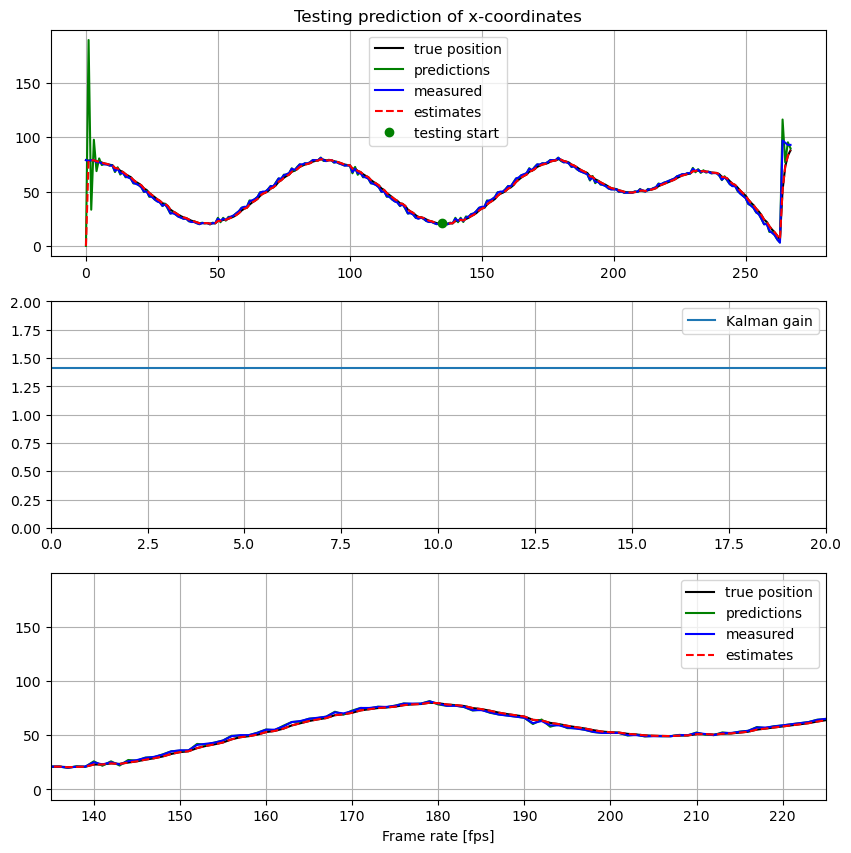

In [722]:
x_est = np.zeros((Nx,N))
x_pred = np.zeros((Nx,N))
# x_est[0,0] = x_est_last
# x_pred[0,0] = x_pred_last
I = np.eye(Nx)
for n in range(1,N):
    x_est[:,n] = x_pred[:,n-1] + K[:,:,n]@(z[n] - H @ x_pred[:,n-1])
    x_pred[:,n] = F @ x_est[:,n]



print(K.shape)

indekse = np.arange(0,N)
plt.figure(figsize=(10, 10))
plt.subplot(3,1,1)
plt.title('Testing prediction of x-coordinates')
plt.plot(indekse,z,'k-',label='true position')
plt.plot(indekse,x_pred[0,:],'g-',label='predictions')
plt.plot(indekse,x_coords,'b-',label='measured')
plt.plot(indekse,x_est[0,:],'r--',label='estimates')
plt.plot(N_train, z[N_train], 'go', label = 'testing start')
plt.grid('true')
plt.legend()

plt.subplot(3,1,2)
plt.plot(indekse,K[1,0,:], label = 'Kalman gain')
plt.xlim(0,20)
plt.ylim(0,2)
plt.legend()
plt.grid('true')

plt.subplot(3,1,3)
plt.plot(indekse,z,'k-',label='true position')
plt.plot(indekse,x_pred[0,:],'g-',label='predictions')
plt.plot(indekse,x_coords,'b-',label='measured')
plt.plot(indekse,x_est[0,:],'r--',label='estimates')
plt.xlim(N_train,225)
# plt.ylim(100,300)
plt.legend()
plt.grid('true')
plt.xlabel('Frame rate [fps]')
plt.show()

Qualitatively we can clearly see that the prediction algorithm works very well, when predicting one time step into the future. Thus the Kalman gain calculated in the training phase was correct. We will also analyse it quantitatively by calculating the absolute and relative errors.

##### Error calculations

In [723]:
# Calculate absolute and relative errors
true_values = z[N_train:]  #x_coords[N_train:]
pred_values = x_pred[0, N_train:]
est_values = x_est[0, N_train:]
abs_errors_pred = np.abs(true_values - pred_values)
abs_errors_est = np.abs(true_values - est_values)

rel_errors_pred = (abs_errors_pred / true_values) * 100
rel_errors_est = (abs_errors_est / true_values) * 100

# Print average absolute and relative errors
print("Average Absolute Error (Predictions):", round(np.mean(abs_errors_pred),2), "pixels")
print("Average Relative Error (Predictions):", round(np.mean(rel_errors_pred),2), "%")
print("Average Absolute Error (Estimates):", round(np.mean(abs_errors_est),2), "pixels")
print("Average Relative Error (Estimates):", round(np.mean(rel_errors_est),2), "%")

Average Absolute Error (Predictions): 2.07 pixels
Average Relative Error (Predictions): 5.12 %
Average Absolute Error (Estimates): 0.0 pixels
Average Relative Error (Estimates): 0.0 %


From the results it can be seen that the estimations are identical to the 'true' filtered signal, while the predictions are not far off. Further, when calculating the errors relative to the 'measured' noisy signal, the predictions does perform better compared to the estimations. Finally, we can conclude that the errors are small enough with values within 2 pixels, which is sufficient for this practical. 

#### Testing model (multiple frames into future)

Now, we can analyse the prediction algorithm multiple steps into the future and compare the results.

In [724]:
z = kalmanfilter_x
N = z.size
print(z.size)
K = np.zeros((Nx,Nz,N))
K[1,0,:] = K_ss
K[0,0,:] = 1

268


(2, 1, 268)


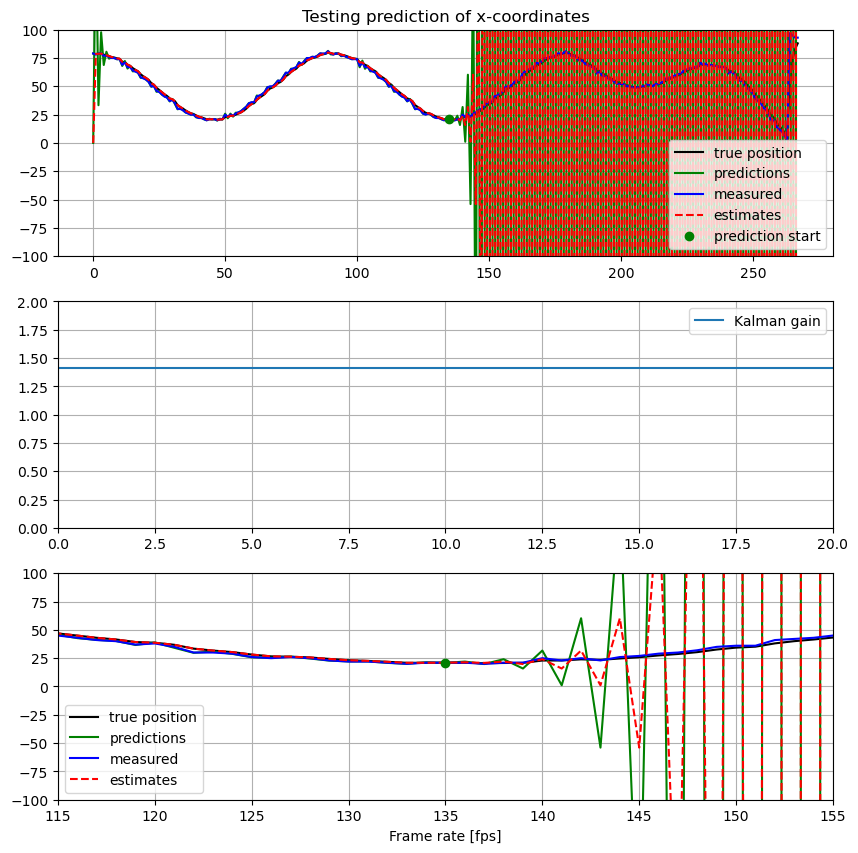

In [728]:
x_est = np.zeros((Nx,N))
x_pred = np.zeros((Nx,N))
temp_x_est = np.zeros((Nx,N))
temp_x_pred = np.zeros((Nx,N))
# temp_x_est = np.full((Nx, N), np.nan)
# temp_x_pred = np.full((Nx, N), np.nan)
I = np.eye(Nx)

n = 1
while n < N:
    if ((n <= N_train)):
        # Use true values for the rest of the iterations
        x_est[:, n] = x_pred[:, n-1] + K[:, :, n] @ (z[n] - H @ x_pred[:, n-1])
    else:
        # Use previous prediction for every 5th iteration
        x_est[:, n] = x_pred[:, n-1] + K[:, :, n] @ (H @ x_pred[:, n-2] - H @ x_pred[:, n-1])
    
    x_pred[:, n] = F @ x_est[:, n]
    n += 1


print(K.shape)

indekse = np.arange(0,N)
plt.figure(figsize=(10, 10))
plt.subplot(3,1,1)
plt.title('Testing prediction of x-coordinates')
plt.plot(indekse,z,'k-',label='true position')
plt.plot(indekse,x_pred[0,:],'g-',label='predictions')
plt.plot(indekse,x_coords,'b-',label='measured')
plt.plot(indekse,x_est[0,:],'r--',label='estimates')
plt.plot(N_train, z[N_train], 'go', label = 'prediction start')
# plt.plot(150, z[150], 'go', label = '5 frame prediction ends')
plt.grid('true')
plt.ylim(-100,100)
# plt.xlim(130,160)
plt.legend()

plt.subplot(3,1,2)
plt.plot(indekse,K[1,0,:], label = 'Kalman gain')
plt.xlim(0,20)
plt.ylim(0,2)
plt.legend()
plt.grid('true')

plt.subplot(3,1,3)
plt.plot(indekse,z,'k-',label='true position')
plt.plot(indekse,x_pred[0,:],'g-',label='predictions')
plt.plot(indekse,x_coords,'b-',label='measured')
plt.plot(indekse,x_est[0,:],'r--',label='estimates')
plt.xlim(N_train-20,N_train+20)
plt.plot(N_train, z[N_train], 'go')
plt.ylim(-100,100)
plt.legend()
plt.grid('true')
plt.xlabel('Frame rate [fps]')
plt.show()

Qualitative interpretation,

Because this method uses the previous predicted value, $x_{pred}$ as the measured value, $z[n]$, the error increases exponentially from where the prediction starts. An alternative approach would be to follow a trend, which will act as the 'measured values', $z[n]$, for the algorithm, but will also not incorporate the seasonality of the data. Next we can confirm this result quantitatively by again calculating the errors.

##### Error calculations

In [729]:
steps = [1, 5, 10, 15]

for i in steps:
    predicted_value = x_pred[0,N_train+i]
    true_value = z[N_train+i] #x_coords[N_train+i]
    abs_error = abs(predicted_value - true_value)
    rel_error = (abs(predicted_value - true_value) / true_value) * 100
    print('For frame ', i, ', Abs error: ', round(abs_error,2), 'pixels, Relative error: ', round(rel_error,2), '%')

For frame  1 , Abs error:  1.02 pixels, Relative error:  4.84 %
For frame  5 , Abs error:  8.82 pixels, Relative error:  38.46 %
For frame  10 , Abs error:  284.92 pixels, Relative error:  1101.64 %
For frame  15 , Abs error:  7495.76 pixels, Relative error:  21839.92 %


As visually inspected the error increases exponentially when increasing the number of prediction frames. For practical purposes this algorithm is only reliable for 1 or 2 frames into the future.

### y-coordinates

#### Testing model (one frame into future)

In [730]:
z = y_signal
N = z.size
print(z.size)
K = np.zeros((Nx,Nz,N))
K[1,0,:] = K_ss
K[0,0,:] = 1

268


(2, 1, 268)


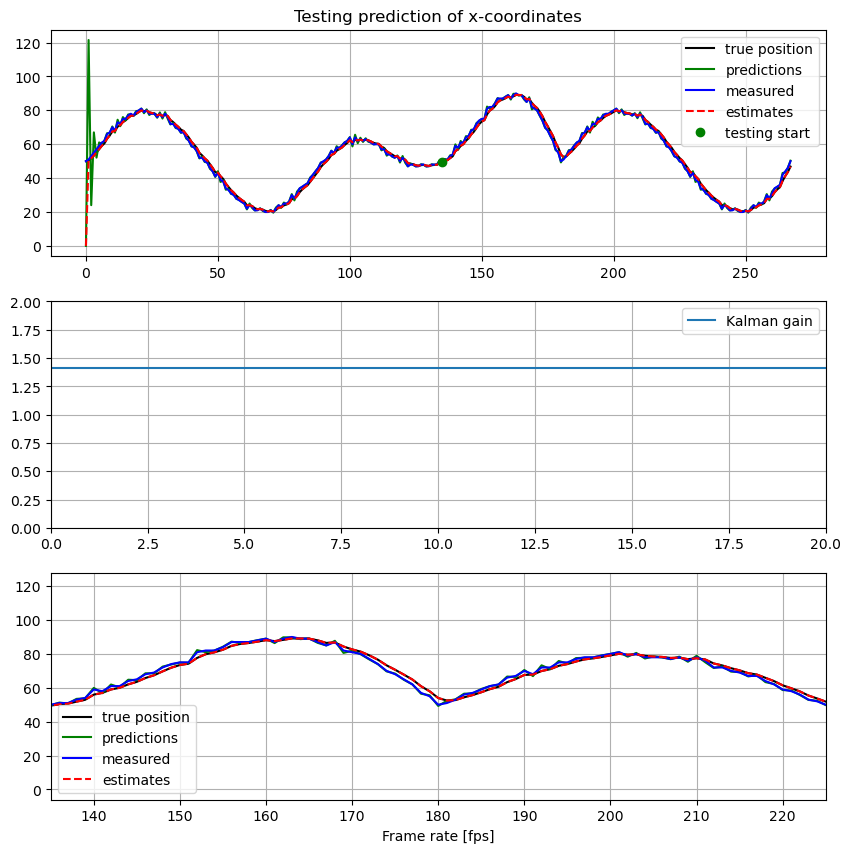

In [731]:
x_est = np.zeros((Nx,N))
x_pred = np.zeros((Nx,N))
# x_est[0,0] = x_est_last
# x_pred[0,0] = x_pred_last
I = np.eye(Nx)
for n in range(1,N):
    x_est[:,n] = x_pred[:,n-1] + K[:,:,n]@(z[n] - H @ x_pred[:,n-1])
    x_pred[:,n] = F @ x_est[:,n]

print(K.shape)

indekse = np.arange(0,N)
plt.figure(figsize=(10, 10))
plt.subplot(3,1,1)
plt.title('Testing prediction of x-coordinates')
plt.plot(indekse,z,'k-',label='true position')
plt.plot(indekse,x_pred[0,:],'g-',label='predictions')
plt.plot(indekse,y_coords,'b-',label='measured')
plt.plot(indekse,x_est[0,:],'r--',label='estimates')
plt.plot(N_train, z[N_train], 'go', label = 'testing start')
plt.grid('true')
plt.legend()

plt.subplot(3,1,2)
plt.plot(indekse,K[1,0,:], label = 'Kalman gain')
plt.xlim(0,20)
plt.ylim(0,2)
plt.legend()
plt.grid('true')

plt.subplot(3,1,3)
plt.plot(indekse,z,'k-',label='true position')
plt.plot(indekse,x_pred[0,:],'g-',label='predictions')
plt.plot(indekse,y_coords,'b-',label='measured')
plt.plot(indekse,x_est[0,:],'r--',label='estimates')
plt.xlim(N_train,225)
# plt.ylim(100,300)
plt.legend()
plt.grid('true')
plt.xlabel('Frame rate [fps]')
plt.show()

##### Error calculations

In [732]:
# Calculate absolute and relative errors
true_values = z[N_train:]  #x_coords[N_train:]
pred_values = x_pred[0, N_train:]
est_values = x_est[0, N_train:]
abs_errors_pred = np.abs(true_values - pred_values)
abs_errors_est = np.abs(true_values - est_values)

rel_errors_pred = (abs_errors_pred / true_values) * 100
rel_errors_est = (abs_errors_est / true_values) * 100

# Print average absolute and relative errors
print("Average Absolute Error (Predictions):", round(np.mean(abs_errors_pred),2), "pixels")
print("Average Relative Error (Predictions):", round(np.mean(rel_errors_pred),2), "%")
print("Average Absolute Error (Estimates):", round(np.mean(abs_errors_est),2), "pixels")
print("Average Relative Error (Estimates):", round(np.mean(rel_errors_est),2), "%")

Average Absolute Error (Predictions): 1.6 pixels
Average Relative Error (Predictions): 3.2 %
Average Absolute Error (Estimates): 0.0 pixels
Average Relative Error (Estimates): 0.0 %


Same conclusion as with x-coordinates.

#### Testing model (multiple frames into future)

In [733]:
z = kalmanfilter_y
N = z.size
print(z.size)
K = np.zeros((Nx,Nz,N))
K[1,0,:] = K_ss
K[0,0,:] = 1

268


(2, 1, 268)


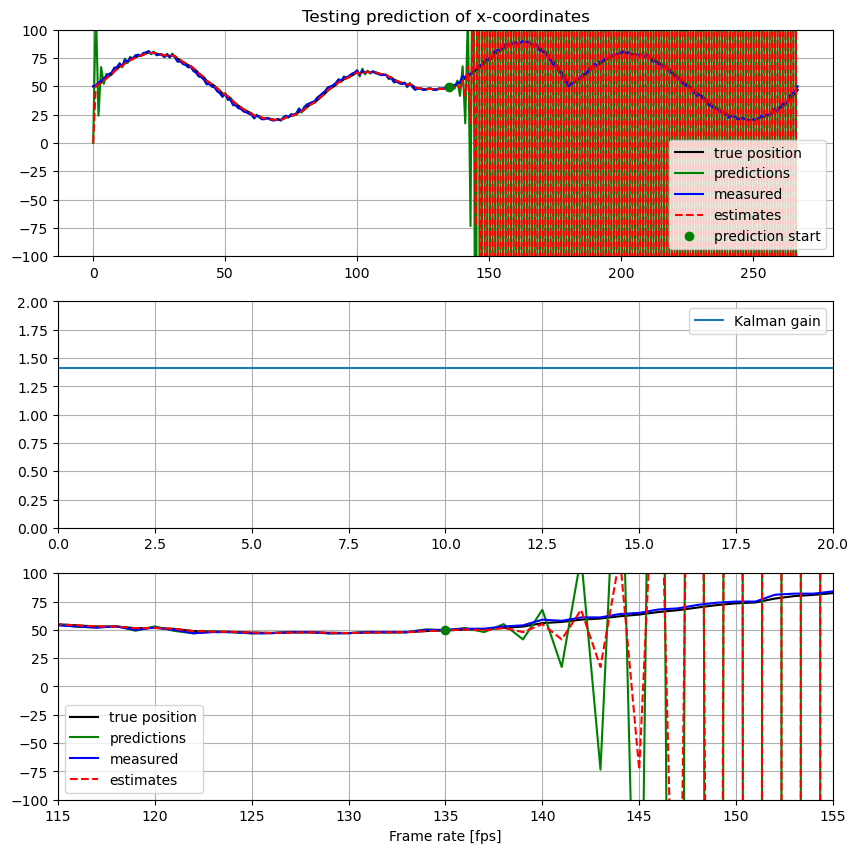

In [734]:
x_est = np.zeros((Nx,N))
x_pred = np.zeros((Nx,N))
temp_x_est = np.zeros((Nx,N))
temp_x_pred = np.zeros((Nx,N))
# temp_x_est = np.full((Nx, N), np.nan)
# temp_x_pred = np.full((Nx, N), np.nan)
I = np.eye(Nx)

n = 1
while n < N:
    if ((n <= N_train)):
        # Use true values for the rest of the iterations
        x_est[:, n] = x_pred[:, n-1] + K[:, :, n] @ (z[n] - H @ x_pred[:, n-1])
    else:
        # Use previous prediction for every 5th iteration
        x_est[:, n] = x_pred[:, n-1] + K[:, :, n] @ (H @ x_pred[:, n-2] - H @ x_pred[:, n-1])
    
    x_pred[:, n] = F @ x_est[:, n]
    n += 1


print(K.shape)

indekse = np.arange(0,N)
plt.figure(figsize=(10, 10))
plt.subplot(3,1,1)
plt.title('Testing prediction of x-coordinates')
plt.plot(indekse,z,'k-',label='true position')
plt.plot(indekse,x_pred[0,:],'g-',label='predictions')
plt.plot(indekse,y_coords,'b-',label='measured')
plt.plot(indekse,x_est[0,:],'r--',label='estimates')
plt.plot(N_train, z[N_train], 'go', label = 'prediction start')
# plt.plot(150, z[150], 'go', label = '5 frame prediction ends')
plt.grid('true')
plt.ylim(-100,100)
# plt.xlim(130,160)
plt.legend()

plt.subplot(3,1,2)
plt.plot(indekse,K[1,0,:], label = 'Kalman gain')
plt.xlim(0,20)
plt.ylim(0,2)
plt.legend()
plt.grid('true')

plt.subplot(3,1,3)
plt.plot(indekse,z,'k-',label='true position')
plt.plot(indekse,x_pred[0,:],'g-',label='predictions')
plt.plot(indekse,y_coords,'b-',label='measured')
plt.plot(indekse,x_est[0,:],'r--',label='estimates')
plt.xlim(N_train-20,N_train+20)
plt.plot(N_train, z[N_train], 'go')
plt.ylim(-100,100)
plt.legend()
plt.grid('true')
plt.xlabel('Frame rate [fps]')
plt.show()

##### Error calculations

In [735]:
steps = [1, 5, 10, 15]

for i in steps:
    predicted_value = x_pred[0,N_train+i]
    true_value = z[N_train+i] #y_coords[N_train+i]
    abs_error = abs(predicted_value - true_value)
    rel_error = (abs(predicted_value - true_value) / true_value) * 100
    print('For frame ', i, ', Abs error: ', round(abs_error,2), 'pixels, Relative error: ', round(rel_error,2), '%')

For frame  1 , Abs error:  1.38 pixels, Relative error:  2.74 %
For frame  5 , Abs error:  11.75 pixels, Relative error:  20.99 %
For frame  10 , Abs error:  474.54 pixels, Relative error:  747.14 %
For frame  15 , Abs error:  12339.06 pixels, Relative error:  16801.41 %


Again, very bad results for predictions above 1 or 2 frames. 

## Time series

Using time series analyses, we can create an accurate model that predicts the position of the UFO for far more than just one frame, with this technique introducing concepts such as stationarity, seasonality and auto-correlation which is used to improve the overall prediction model.

**Autocorrelation** is the similarity between observations as a function of the time lag between them [9]. 

**Seasonality** refers to periodic fluctuations. It can also be derived from an autocorrelation plot if it has a sinusoidal shape [9]. 

A time series is said to be **stationary** if its statistical properties don’t change over time. That is constant mean and variance over time. These are several other tests that can test stationarity such as Dicky Fuller that will be utilised in this practical. It evaluates the null hypothesis to determine if a unit root is present. If the equation returns p>0, then the process is not stationary. If p=0, then the process is considered stationary [9].

We will make use of a **SARIMA** model defining each parameter. This is actually the combination of simpler models that create a complex model that can present a time series exhibiting non-stationary properties and seasonality [9]. These simpler models include,

**Autoregression model**, AR(p), yhis is basically a regression of the time series onto itself. To get its parameter p, we look at the partial autocorrelation plot and identify the lag after which most lags are not significant [9].

Next, the **moving average model** MA(q). This takes a parameter q which represents the biggest lag after which other lags are not significant on the autocorrelation plot [9].

Other parameter include **order of integration** I(d). The parameter d represents the number of differences required to make the series stationary [9].

Finally, we’ll add the final component: **seasonality** S(P, D, Q, s), where s is simply the season’s length [9]. Combining all, we get the **SARIMA (p, d, q)(P, D, Q, s)** model.

To develop the prediction model the following procedure shall be followed,

1. Check stationarity and transform if required.
2. Assign parameter values to the SARIMA model.
3. Tentative identification of model order and seasonal order.
4. Train model.
5. Evaluate model and change is nessesary.
6. Implement model to predict future values.

### x-coordinates

#### Test for stationarity

We compute the mean and standrd deviation of the filtered signal gained from the Kalman filter n Part 2.We do this by defining a window size and sliding it over the signal while calculating the values.

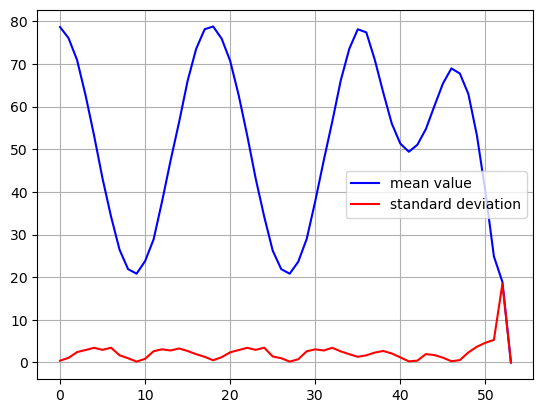

In [737]:
df = pd.read_csv(csv_file_path)
x_signal = kalmanfilter_x
y_signal = kalmanfilter_y

N = len(x_signal)
Nwindow = 5
mu = np.zeros((N//Nwindow)+1)
sigma = np.zeros((N//Nwindow)+1)

k = 0
n = Nwindow
while (n<N):
    mu[k] = np.mean(x_signal[n-Nwindow:n])
    sigma[k] = np.std(x_signal[n-Nwindow:n],ddof=1)
    k = k + 1
    n = n + Nwindow

plt.figure()
plt.plot(mu,'b',label='mean value')
plt.plot(sigma,'r',label='standard deviation')
plt.legend()
plt.grid('true')

Both the mean and standard deviation seems to stay within a certain limit, with the mean having a strong seasonal component. However, the last few frames, the amplitude differs, while the seasonal trend stays constant, which ultimately will make prediction from that point much more difficult.

Further, stationarity can be confirmed using the Dicky Fuller test and observing the auto correlation plot.

P value:  0.016790185376383108


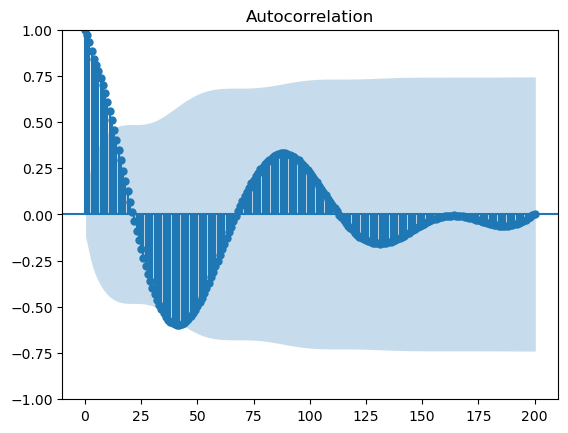

In [739]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(x_signal, lags = 200)

from statsmodels.tsa.stattools import adfuller
out = adfuller(x_signal)
print('P value: ', out[1])

With the auto correlation function having a strong seasonal component and total area converging we can conclude that the signal is stationary. Furhermore, the p-value of the Dickey-Fuller Test, is within 95% CI (less than 0.05), thus we reject the null hypothesis and can conclude that the data is stationary. This is understandable as the UFO aways stay within a frame, and cannot exceed certain boundaries.

#### General model identification

Next, we identify the model by observing the auto- and partial auto correlation plots to determine the SARIMA parameter values.

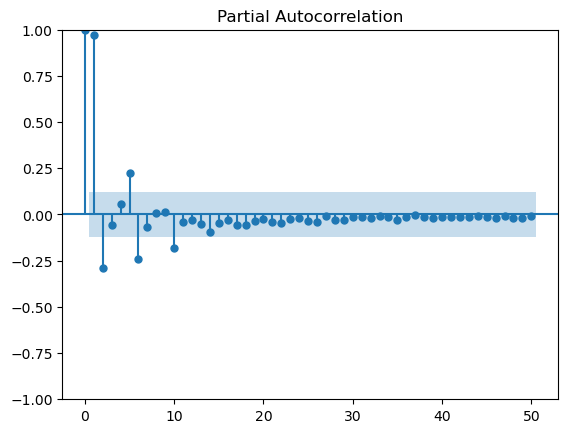

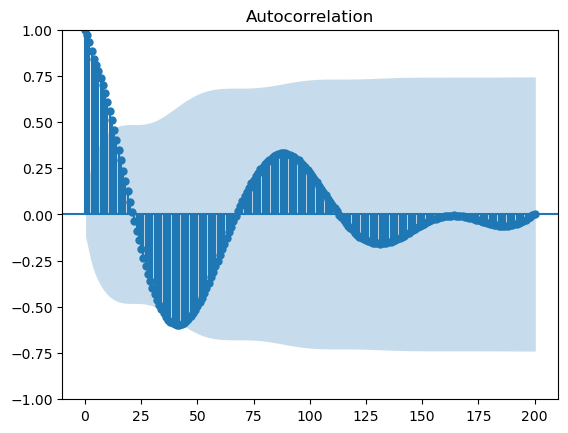

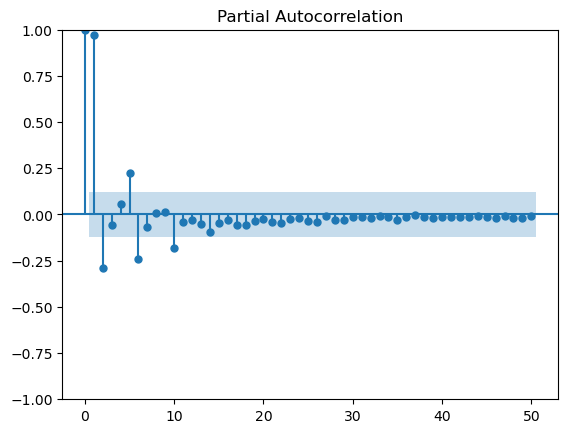

In [740]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(x_signal, lags=200)
plot_pacf(x_signal, lags=50)

The auto correlation shows a very strong seasonal component, with a period of around 90 samples, that needs to be modelled for accurate prediction. From the partial auto correlation plot, it can be seen that the both q and p values shall be chosen as 1 or 2 and their respective RMS values of the residuals calculated to minimise the error. Next, no integration (d) parameter will be used due to the data already being stationary, and requireds 0 differencing.

#### Fit model

First, we divide the model into its respective testing and training data, choosing again a split of 50%.

In [758]:
y = x_signal
N1 = len(y)
Ntrain = int(N1*0.5)
print('Number of training samples: ',Ntrain)
y_train = y[0:Ntrain]
y_test = y[Ntrain:]

Number of training samples:  134


In [759]:
from statsmodels.tsa.arima.model import ARIMA

p = 1     #2 for first model
q = 1     #2 for first model

# ARMAmodel = ARIMA(y_train, order=(p, 0, q))
ARMAmodel = ARIMA(y_train,order=(p,0,q),seasonal_order=(p,0,q,90),trend='ct')
ARMAresults = ARMAmodel.fit()
print(ARMAresults.summary())
print('statsmodels coefficients: ',ARMAresults.params[1:3])

c:\Users\User\miniconda3\envs\signal3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\User\miniconda3\envs\signal3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  134
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 90)   Log Likelihood                -146.139
Date:                          Sat, 01 Jun 2024   AIC                            306.279
Time:                                  12:11:58   BIC                            326.564
Sample:                                       0   HQIC                           314.522
                                          - 134                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.9315     32.610      1.562      0.118     -12.983     114.846
x1          6.584e-05      0.036      0.002      0.

#### Evaluate the model

Once a potential model has been fitted to data, the fidelity of the model has to be tested. Three techniques are commonly used to validate a time series model, namely:
1. Analysis of the residuals obtained when the model is applied to the available data. First and foremost the residuals should be uncorrelated. The autocorrelation function (ACF) is quite useful in this regard.
2. In addition the residuals should also have a Gaussian distribution. This can be determined with a normal Q-Q plot. In addition formal hypothesis tests can be employed e.g. the Shapiro-Wilk test amongst others)
3. If more than one model has been fitted (e.g. ARMA(p,q) models for a range of p and q values) then the RMS value of the residuals calculated on the test subset of data can be compared for the  various model options.

Test for normal distribution, RMS and PP plots on residuals.

Shapiro-Wilk test
-----------------
Statistic =  0.31778772152644974 , p =  2.6884002098059305e-22
Reject nul-hypothesis: sample not Gaussian
D'Agostino's K^2 test
---------------------
Statistic =  261.02084233964405 , p =  2.0895090432350583e-57
Reject nul-hypothesis: sample not Gaussian
RMS value of residuals: 2.618698680468701


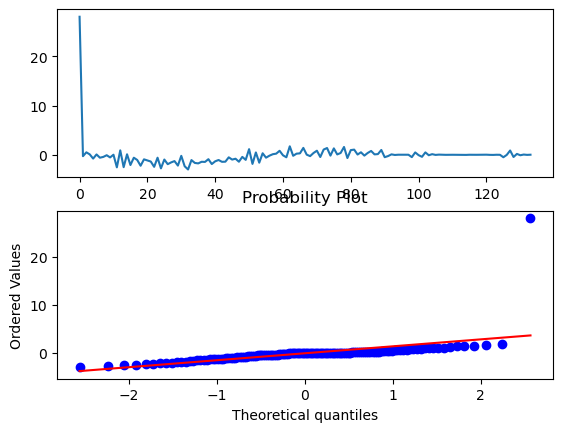

<Figure size 640x480 with 0 Axes>

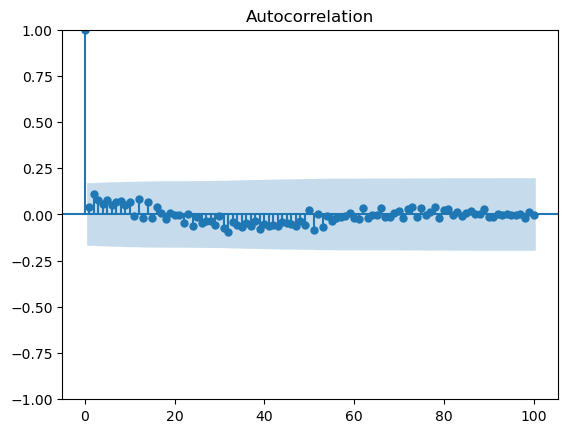

In [761]:
residuals = ARMAresults.resid
from scipy import stats

plt.figure()
plt.tight_layout()
plt.subplot(2,1,1)
plt.plot(residuals)
plt.subplot(2,1,2)
stats.probplot(residuals,dist='norm',plot=plt)

plt.figure()
plot_acf(residuals, lags = 100)

alpha = 0.05

print('Shapiro-Wilk test')
print('-----------------')
stat,p = stats.shapiro(residuals)
print('Statistic = ',stat,', p = ',p)
if (p < alpha):
	print('Reject nul-hypothesis: sample not Gaussian')
else:
	print('Fail to reject H0: sample probably Gaussian')
#	----------------------------------------------------------------
print("D'Agostino's K^2 test")
print('---------------------')
stat,p = stats.normaltest(residuals)
print('Statistic = ',stat,', p = ',p)
if (p < alpha):
	print('Reject nul-hypothesis: sample not Gaussian')
else:
	print('Fail to reject H0: sample probably Gaussian')


print(f"RMS value of residuals: {np.sqrt(np.mean(np.square(residuals)))}")

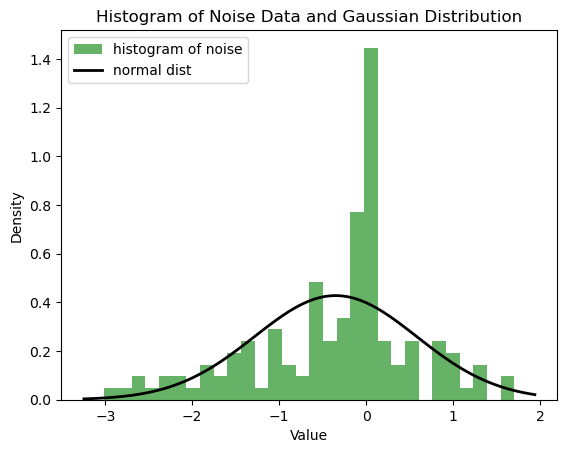

In [762]:
x_noise = residuals[2:] #excluding start and end

# Plot histogram of the data
plt.hist(x_noise, bins=30, density=True, alpha=0.6, color='g', label = 'histogram of noise')

# Plot Gaussian distribution curve for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(x_noise), np.std(x_noise))
plt.plot(x, p, 'k', linewidth=2, label = 'normal dist')
# plt.xlim(-15,15)
plt.legend()

plt.title("Histogram of Noise Data and Gaussian Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

After evaluation,

Although the Shapiro Wilk test and D'Agostino's K^2 test says the residuals are not guassian, it can clearly be seen that the data is uncorrelated when observing the ACF plot. Further, both guassian plots and probability plots shows that the residuals are Guassian. Lastly, the RMS value of the residuals were also calculated and compared for several ARMA parameters (q,d,p), it can be concluded that the (1,0,1) model provides the best results, with a seasonal component of 90 samples and no integration component.

#### Deploy model for prediction

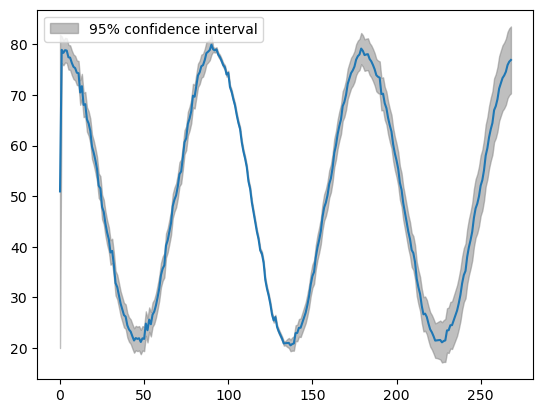

In [763]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots()
fig = plot_predict(ARMAresults, start=0, end=N1, ax=ax)
legend = ax.legend(loc="upper left")
lines = fig.axes[0].lines
predicted_values = lines[0].get_ydata()

The CI is quite narrow to the true signal which is very good, although extending the training data to the last part of the position signal, the prediction struggles to find the true trend and consequenctly the CI widens.

#### Accuracy test

The prediction results are plotted and the respective errors are again calculated.

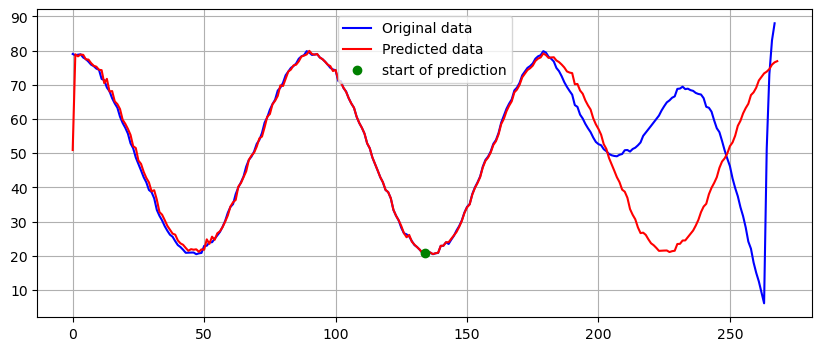

In [767]:
t1 = np.arange(0, len(x_signal), 1)
t2 = np.arange(0, len(predicted_values), 1)
# Plot and compare the data
plt.figure(figsize=(10, 4))
plt.plot(t1, x_signal, 'b', label='Original data')
plt.plot(t2, predicted_values, 'r', label='Predicted data')
plt.plot(Ntrain, predicted_values[Ntrain+1], 'go', label = 'start of prediction')
plt.grid()
plt.legend()
plt.show()

In [773]:
steps = [1, 5, 10, 15, 50]

for i in steps:
    predicted_value = predicted_values[Ntrain+i]
    true_value = x_signal[Ntrain+i]
    abs_error = abs(predicted_value - true_value)
    rel_error = (abs(predicted_value - true_value) / true_value) * 100
    print('For frame ', i, ', Abs error: ', round(abs_error,2), 'pixels, Relative error: ', round(rel_error,2), '%')

For frame  1 , Abs error:  0.01 pixels, Relative error:  0.06 %
For frame  5 , Abs error:  0.04 pixels, Relative error:  0.2 %
For frame  10 , Abs error:  0.26 pixels, Relative error:  1.05 %
For frame  15 , Abs error:  0.14 pixels, Relative error:  0.42 %
For frame  50 , Abs error:  2.18 pixels, Relative error:  2.91 %


We can conclude that the time series prediction has very good prediction results even up to 50 frames from our prediction start, staying within 3 pixels. The SARIMA model incorporating the AR, MA and seasonality did prove to fit very well to our position signal. Although this result is very good, changing the amplitude or seasonality later in the signal does severely effect the results (as seen from the plot above), and if further predictions are required, an additional model should be considered. But for this practical, the results are sufficient enough.

### y-coordinates

In [795]:
y = y_signal
N1 = len(y)
Ntrain = int(N1*0.7) #changed to 70% after evaluation
print('Number of training samples: ',Ntrain)
y_train = y[0:Ntrain]
y_test = y[Ntrain:]

Number of training samples:  187


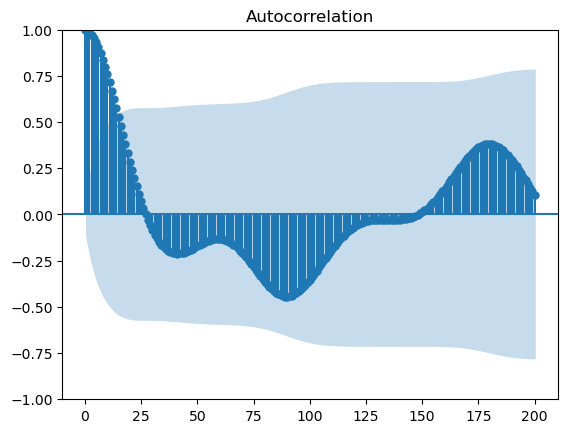

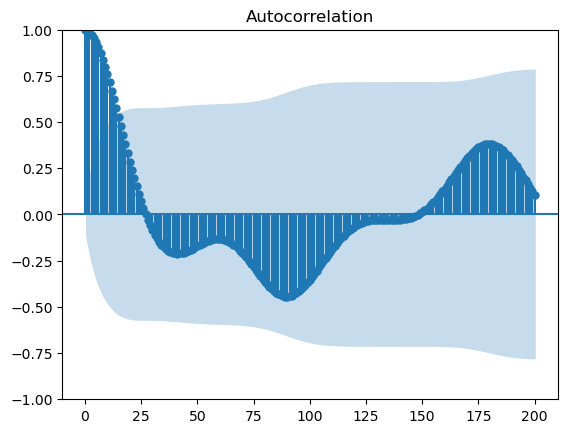

In [796]:
plot_acf(y_signal, lags = 200)

This time the seasonal compoenent is equal to 180 smaples.

In [797]:
p = 1     #2 for first model
q = 1     #2 for first model

# ARMAmodel = ARIMA(y_train, order=(p, 0, q))
ARMAmodel = ARIMA(y_train,order=(p,0,q),seasonal_order=(p,0,q,180),trend='ct')
ARMAresults = ARMAmodel.fit()
print(ARMAresults.summary())
print('statsmodels coefficients: ',ARMAresults.params[1:3])

c:\Users\User\miniconda3\envs\signal3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\User\miniconda3\envs\signal3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  187
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 180)   Log Likelihood                -306.765
Date:                           Sat, 01 Jun 2024   AIC                            627.530
Time:                                   12:51:03   BIC                            650.148
Sample:                                        0   HQIC                           636.695
                                           - 187                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.5368     47.173      1.071      0.284     -41.921     142.994
x1             0.0200      0.076      0.262

Shapiro-Wilk test
-----------------
Statistic =  0.994771501027673 , p =  0.7591619389284672
Fail to reject H0: sample probably Gaussian
D'Agostino's K^2 test
---------------------
Statistic =  0.7930615934718902 , p =  0.6726495609713359
Fail to reject H0: sample probably Gaussian
RMS value of residuals: 1.2411447455188218


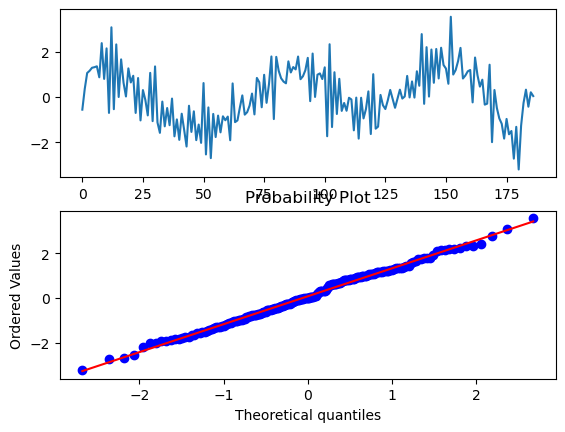

<Figure size 640x480 with 0 Axes>

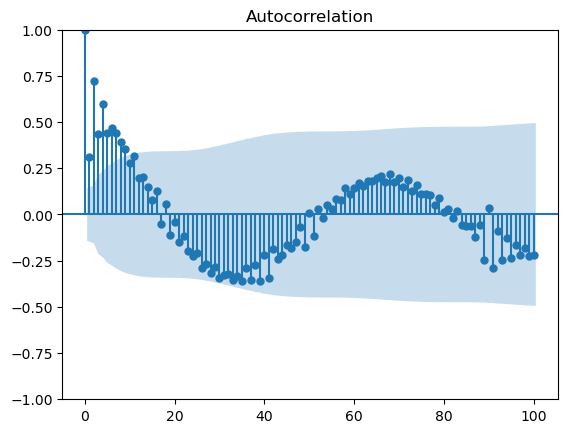

In [798]:
residuals = ARMAresults.resid
from scipy import stats

plt.figure()
plt.tight_layout()
plt.subplot(2,1,1)
plt.plot(residuals)
plt.subplot(2,1,2)
stats.probplot(residuals,dist='norm',plot=plt)

plt.figure()
plot_acf(residuals, lags = 100)

alpha = 0.05

print('Shapiro-Wilk test')
print('-----------------')
stat,p = stats.shapiro(residuals)
print('Statistic = ',stat,', p = ',p)
if (p < alpha):
	print('Reject nul-hypothesis: sample not Gaussian')
else:
	print('Fail to reject H0: sample probably Gaussian')
#	----------------------------------------------------------------
print("D'Agostino's K^2 test")
print('---------------------')
stat,p = stats.normaltest(residuals)
print('Statistic = ',stat,', p = ',p)
if (p < alpha):
	print('Reject nul-hypothesis: sample not Gaussian')
else:
	print('Fail to reject H0: sample probably Gaussian')


print(f"RMS value of residuals: {np.sqrt(np.mean(np.square(residuals)))}")

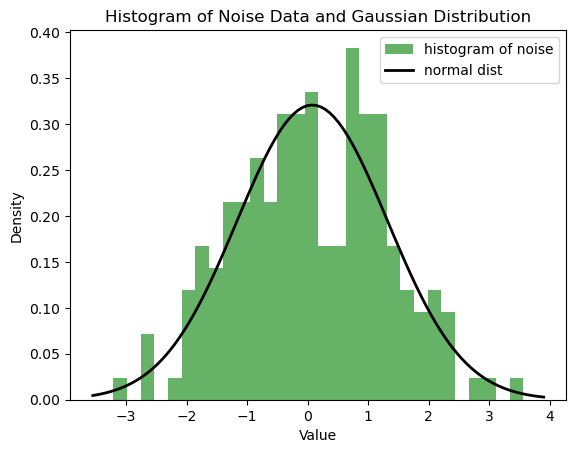

In [799]:
x_noise = residuals[2:] #excluding start and end

# Plot histogram of the data
plt.hist(x_noise, bins=30, density=True, alpha=0.6, color='g', label = 'histogram of noise')

# Plot Gaussian distribution curve for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(x_noise), np.std(x_noise))
plt.plot(x, p, 'k', linewidth=2, label = 'normal dist')
# plt.xlim(-15,15)
plt.legend()

plt.title("Histogram of Noise Data and Gaussian Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

All tests show the residuals following a Guassian distribution.

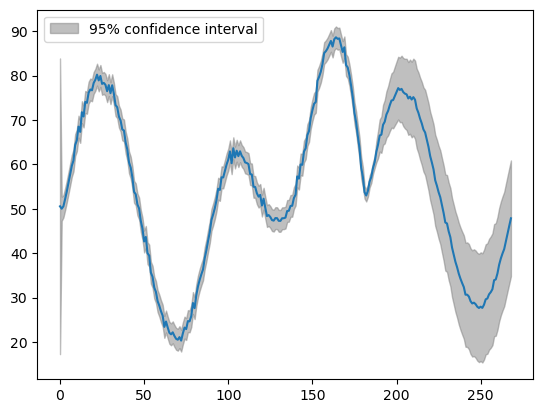

In [800]:
fig, ax = plt.subplots()
fig = plot_predict(ARMAresults, start=0, end=N1, ax=ax)
legend = ax.legend(loc="upper left")
lines = fig.axes[0].lines
predicted_values = lines[0].get_ydata()

Immediately we can see that this model is not as confident in the predictions as with the previous x-coordinates model. With the CI expanding quite quickly from the prediction start.

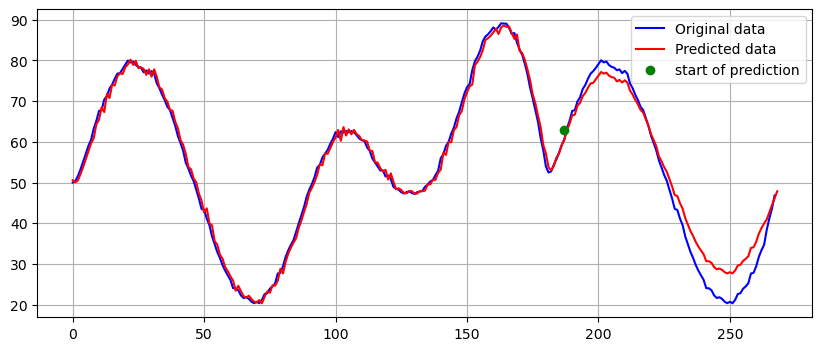

In [801]:
t1 = np.arange(0, len(y_signal), 1)
t2 = np.arange(0, len(predicted_values), 1)
# Plot and compare the data
plt.figure(figsize=(10, 4))
plt.plot(t1, y_signal, 'b', label='Original data')
plt.plot(t2, predicted_values, 'r', label='Predicted data')
plt.plot(Ntrain, predicted_values[Ntrain+1], 'go', label = 'start of prediction')
plt.grid()
plt.legend()
plt.show()

In [802]:
steps = [1, 5, 10, 15, 50, 75]

for i in steps:
    predicted_value = predicted_values[Ntrain+i]
    true_value = y_signal[Ntrain+i]
    abs_error = abs(predicted_value - true_value)
    rel_error = (abs(predicted_value - true_value) / true_value) * 100
    print('For frame ', i, ', Abs error: ', round(abs_error,2), 'pixels, Relative error: ', round(rel_error,2), '%')

For frame  1 , Abs error:  0.5 pixels, Relative error:  0.79 %
For frame  5 , Abs error:  1.0 pixels, Relative error:  1.43 %
For frame  10 , Abs error:  2.39 pixels, Relative error:  3.11 %
For frame  15 , Abs error:  2.76 pixels, Relative error:  3.47 %
For frame  50 , Abs error:  5.68 pixels, Relative error:  19.1 %
For frame  75 , Abs error:  5.44 pixels, Relative error:  16.31 %


The y coordinates prove to much harder to predict, due to changes in directions, much more inconsistantly. After 50% training data was not sufficient, 70 % was chosen that provided much better results. From the qualitative and quantitative analyses it can be seen that from the prediction start the results are quite good, following the correct seasonal trend and close enough to the amplitude. Again, for this practical the results are suffient to predict up to 15 frames within an error of 3 pixels.

# References

[1] https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/

[2] https://blogs.sas.com/content/iml/2017/08/02/retain-principal-components.html

[3] https://www.analyticsvidhya.com/blog/2021/08/sharpening-an-image-using-opencv-library-in-python/

[4] L. Tan and J. Jiang, Digital Signal Processing: Fundamentals and Applications. Academic Press, 2018.

[5] https://www.staff.ncl.ac.uk/oliver.hinton/eee305/Chapter4.pdf

[6] https://www.analyticsvidhya.com/blog/2016/03/pca-practical-guide-principal-component-analysis-python/

[7] https://www.kalmanfilter.net/alphabeta.html

[8] file:///C:/Users/User/Documents/NWU/2024/Semester%201/EERI%20414/Tuts/Tut%204/Claver2023_KalmanFiltering4StocksPricePrediction.pdf

[9] https://builtin.com/data-science/time-series-model

# Appendix A - Position tracking algorithm

Frames per second: 10.0
Resolution: (100, 100)
Frame:  0
UFO location: (79, 50)


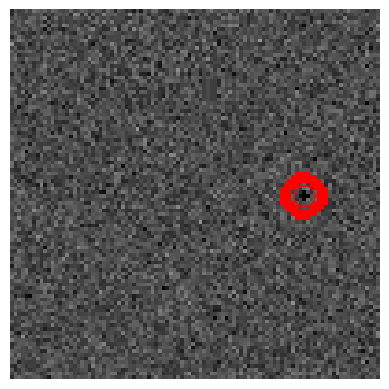

Frame:  1
UFO location: (78, 51)


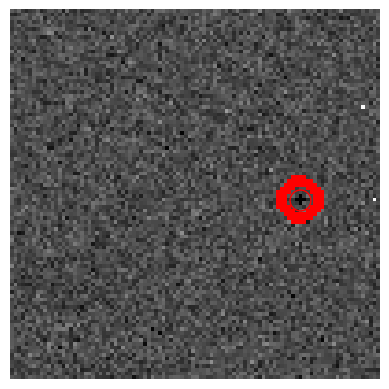

Frame:  2
UFO location: (79, 53)


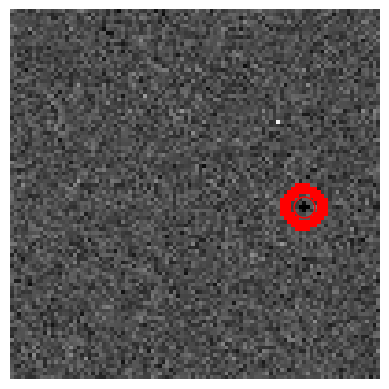

Frame:  3
UFO location: (79, 55)


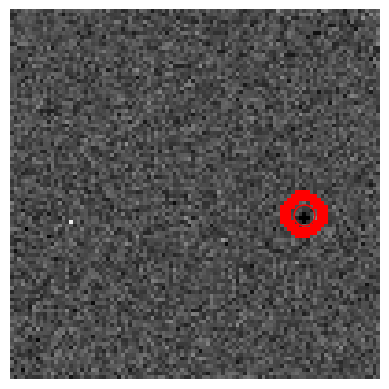

Frame:  4
UFO location: (77, 57)


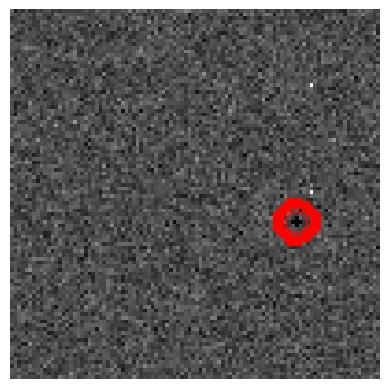

Frame:  5
UFO location: (77, 59)


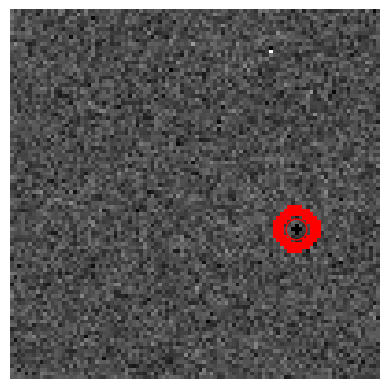

Frame:  6
UFO location: (76, 61)


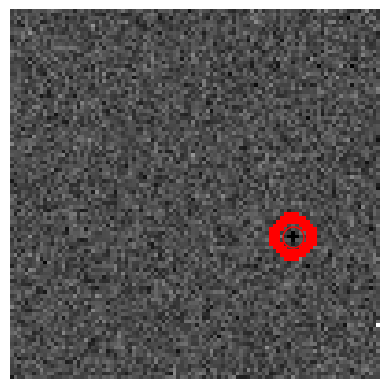

Frame:  7
UFO location: (75, 62)


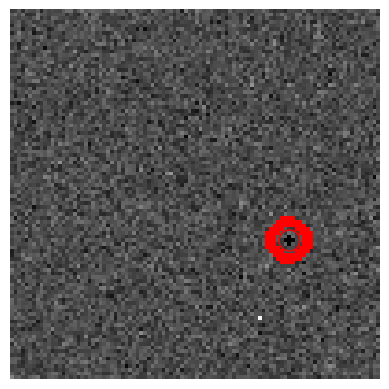

Frame:  8
UFO location: (75, 66)


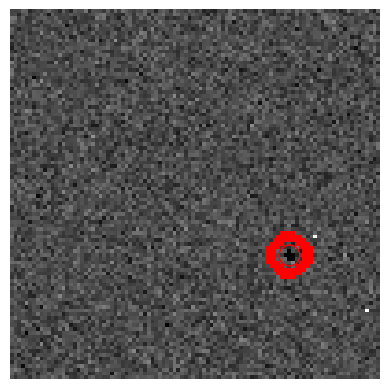

Frame:  9
UFO location: (74, 67)


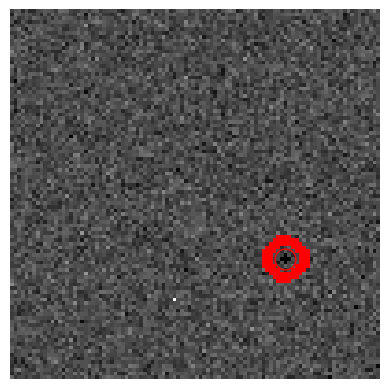

Frame:  10
UFO location: (74, 70)


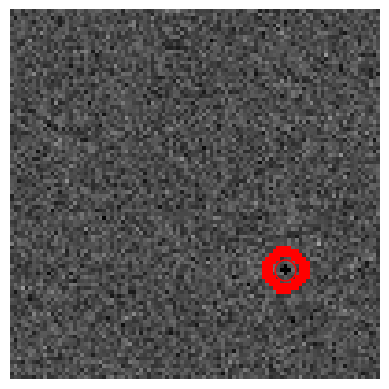

Frame:  11
UFO location: (69, 68)


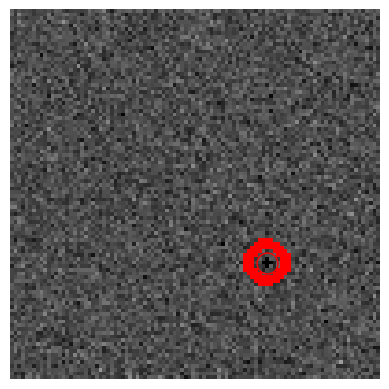

Frame:  12
UFO location: (71, 73)


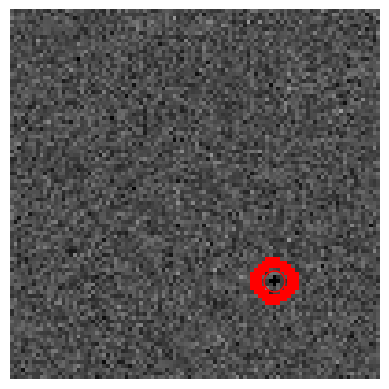

Frame:  13
UFO location: (67, 72)


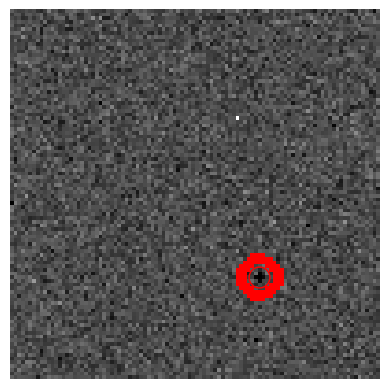

Frame:  14
UFO location: (66, 75)


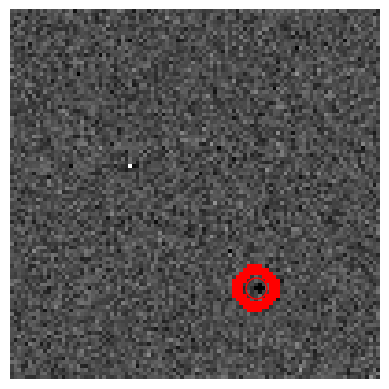

Frame:  15
UFO location: (64, 75)


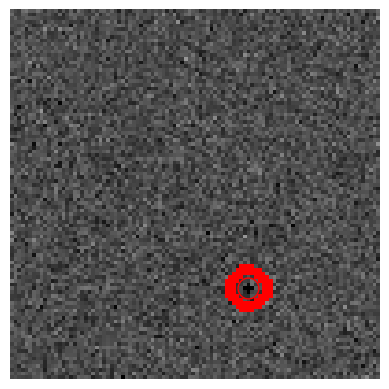

Frame:  16
UFO location: (63, 77)


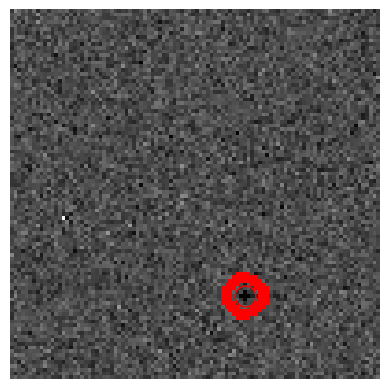

Frame:  17
UFO location: (62, 78)


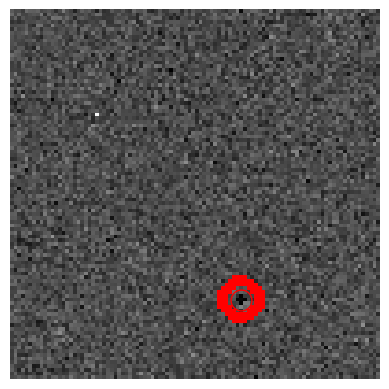

Frame:  18
UFO location: (58, 77)


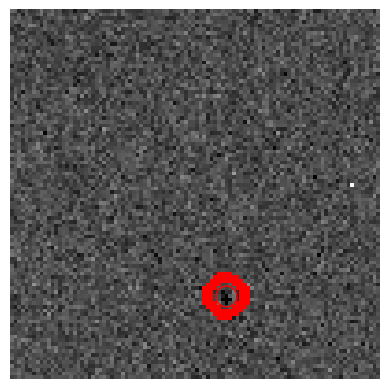

Frame:  19
UFO location: (57, 79)


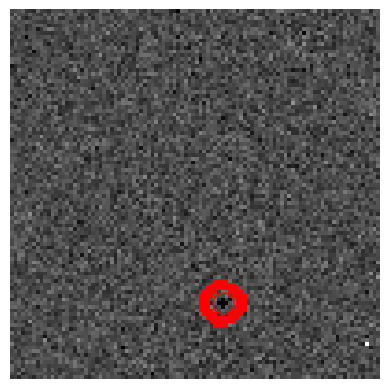

Frame:  20
UFO location: (56, 80)


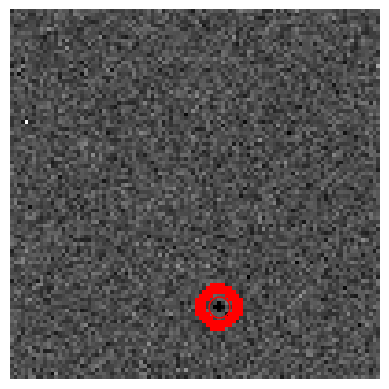

Frame:  21
UFO location: (54, 81)


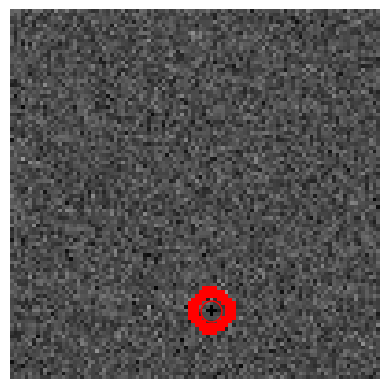

Frame:  22
UFO location: (50, 79)


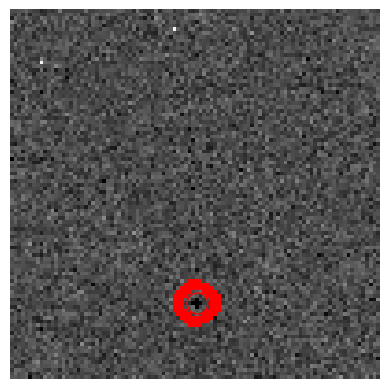

Frame:  23
UFO location: (50, 80)


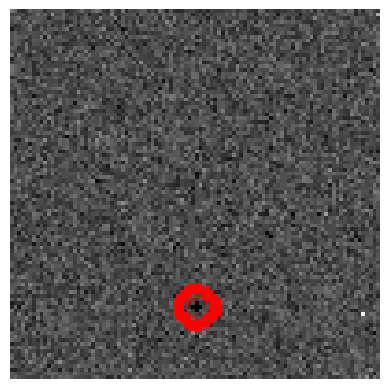

Frame:  24
UFO location: (46, 78)


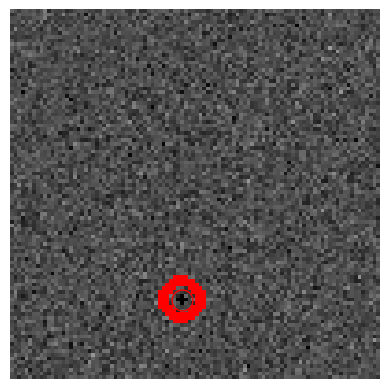

Frame:  25
UFO location: (45, 78)


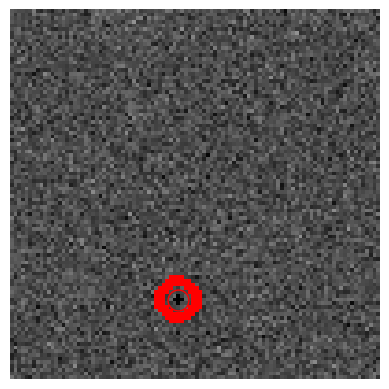

Frame:  26
UFO location: (43, 78)


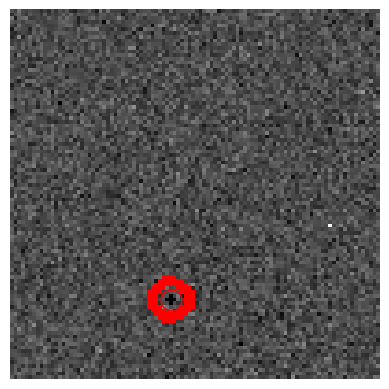

Frame:  27
UFO location: (41, 76)


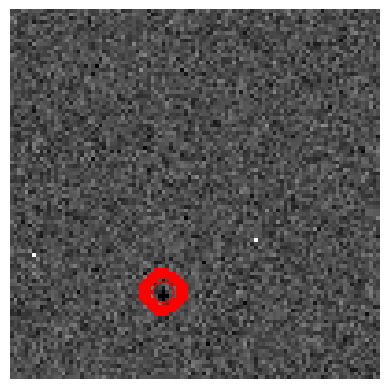

Frame:  28
UFO location: (40, 78)


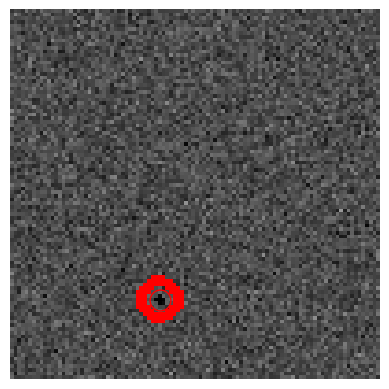

Frame:  29
UFO location: (37, 76)


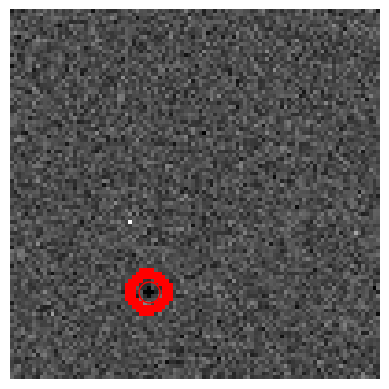

Frame:  30
UFO location: (38, 78)


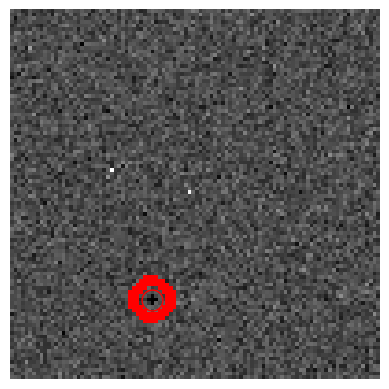

Frame:  31
UFO location: (35, 76)


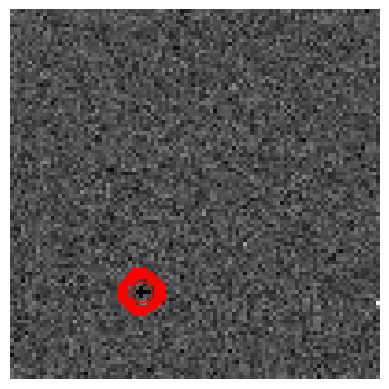

Frame:  32
UFO location: (29, 72)


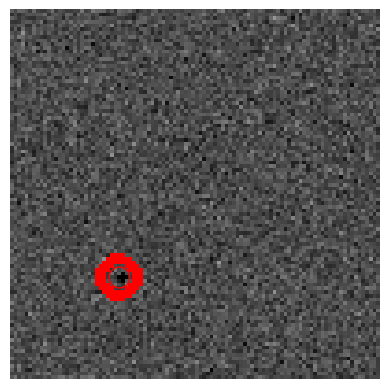

Frame:  33
UFO location: (30, 72)


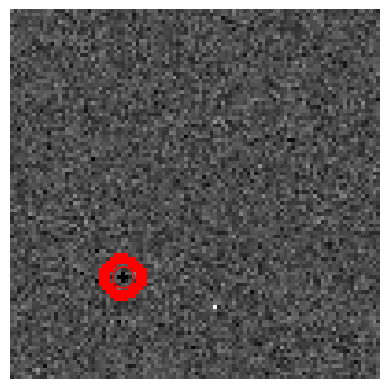

Frame:  34
UFO location: (29, 69)


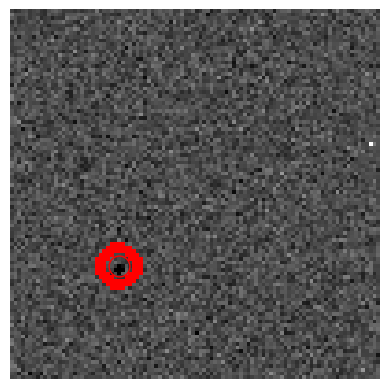

Frame:  35
UFO location: (27, 69)


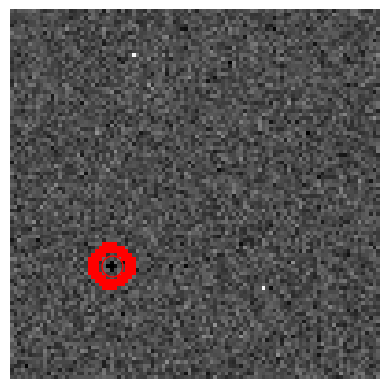

Frame:  36
UFO location: (26, 67)


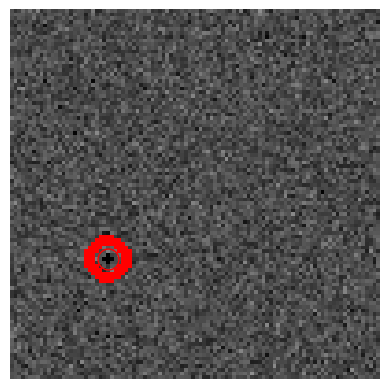

Frame:  37
UFO location: (25, 67)


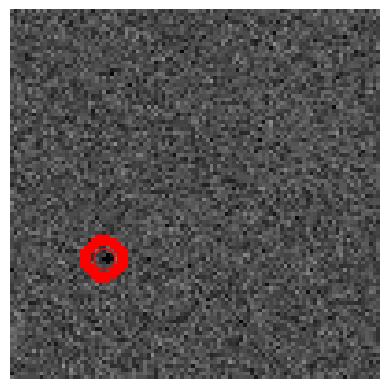

Frame:  38
UFO location: (25, 64)


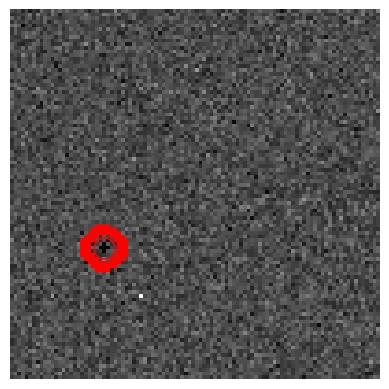

Frame:  39
UFO location: (23, 62)


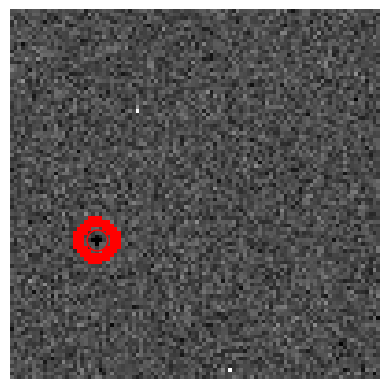

Frame:  40
UFO location: (22, 59)


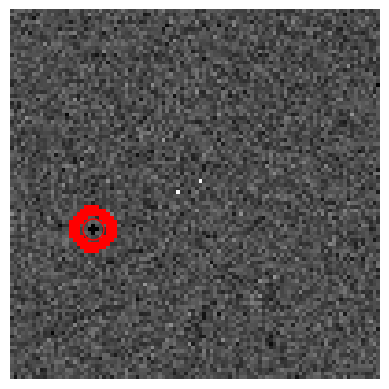

Frame:  41
UFO location: (22, 58)


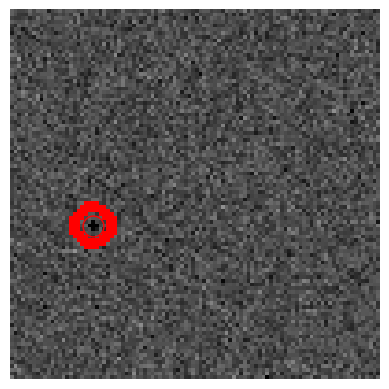

Frame:  42
UFO location: (21, 56)


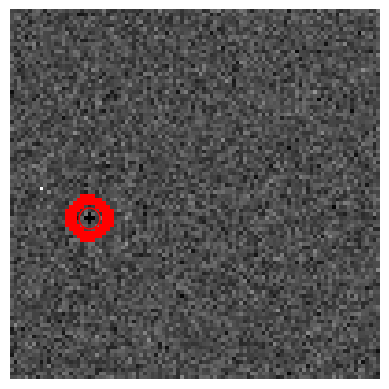

Frame:  43
UFO location: (20, 52)


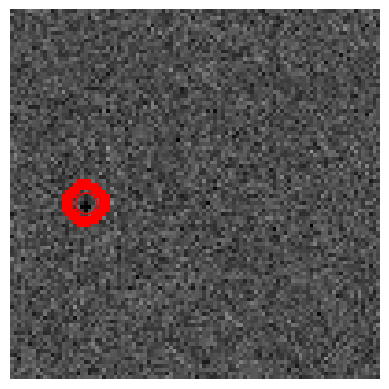

Frame:  44
UFO location: (21, 52)


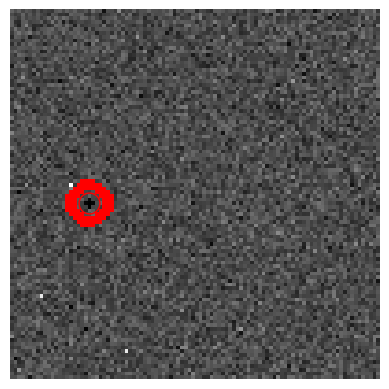

Frame:  45
UFO location: (21, 50)


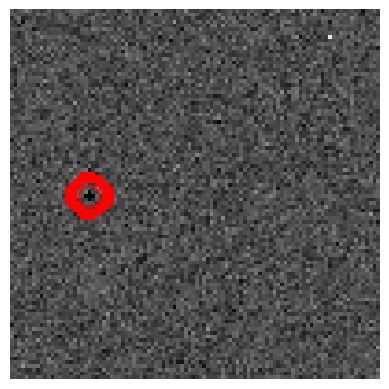

Frame:  46
UFO location: (21, 49)


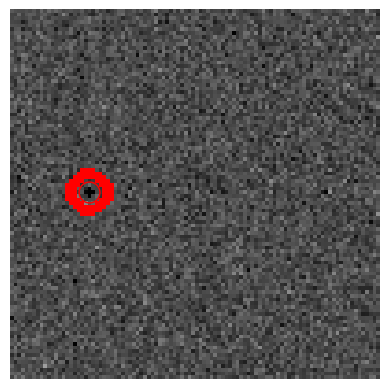

Frame:  47
UFO location: (20, 46)


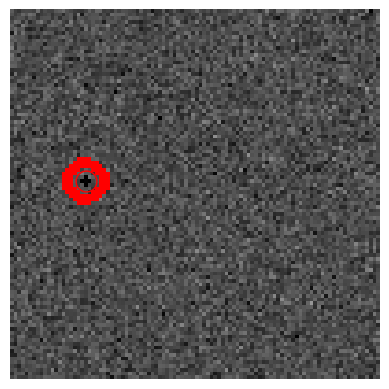

KeyboardInterrupt: 

In [437]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import csv

# import torch
# torch.cuda.is_available()

# torch.cuda.set_device(0)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

def get_fps_and_resolution(video_path):
    # Open the video file
    video_capture = cv2.VideoCapture(video_path)
    
    # Get the frame rate
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    
    # Get the resolution
    width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Release the video capture object
    video_capture.release()
    
    return fps, (width, height)

def transform_and_reconstruct(Nstart, Nstop, X, mu, sorted_eigvec_descending, window_size, num_windows_h, num_windows_w, step):
    Nwindow = window_size**2
    A = np.zeros((Nwindow, Nwindow))
    for n in range(Nstart, Nstop):
        A[n, :] = sorted_eigvec_descending[:, n]

    y = A @ X
    xk = A.T @ y
    for n in range(X.shape[1]):
        xk[:, n] = xk[:, n] + mu

    out = np.zeros((num_windows_h * step + window_size, num_windows_w * step + window_size))
    k = 0
    for i in range(num_windows_h):
        for j in range(num_windows_w):
            out[i * step:i * step + window_size, j * step:j * step + window_size] = xk[:, k].reshape(window_size, window_size)
            k += 1

    return out

def find_white_dot_center(image):
    # Convert the image to grayscale if it's a color image
    if len(image.shape) == 3:
        img_gray = np.mean(image, axis=2).astype(np.uint8)
    else:
        img_gray = image.astype(np.uint8)
    
    # Get the dimensions of the image
    height, width = img_gray.shape
    
    # Iterate through each pixel to find the white dot
    for y in range(height):
        for x in range(width):
            if img_gray[y, x] == 255:  # White pixel (assuming 255 is white in grayscale)
                return (x, y)  # Return the coordinates of the white dot
    
    # If no white dot is found
    return None

def custom_filter2D(image, kernel):
    # Get kernel size
    k_height, k_width = kernel.shape
    
    # Get image size
    height, width = image.shape
    
    # Compute padding size
    pad_height = k_height // 2
    pad_width = k_width // 2
    
    # Pad the image
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='wrap')
    #Wrap optoin was chosen, beacuse zero values confused the threshold algorithm in thinking the UFO is in the corner, where zeros were padded.
    
    # Initialize output image
    output_image = np.zeros_like(image)
    
    # Perform convolution
    for i in range(height):
        for j in range(width):
            output_image[i, j] = np.sum(kernel * padded_image[i:i+k_height, j:j+k_width])
    
    return output_image

def main():
    video_path = "Xfiles.mp4"  # Path to the video file
    fps, resolution = get_fps_and_resolution(video_path)
    print("Frames per second:", fps)
    print("Resolution:", resolution)

    video_capture = cv2.VideoCapture(video_path)

    fps = video_capture.get(cv2.CAP_PROP_FPS)
    frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

    output_path = "UFO_tracking2.mp4"
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 file
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    csv_file_path = "UFO_coordinates2.csv"
    csv_file = open(csv_file_path, mode='w', newline='')
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['frame', 'x_coord', 'y_coord'])  # Write the header

    frame_number = 0

    while True:
        import numpy as np
        ret, frame = video_capture.read()
        if not ret:
            break  # Break the loop if there are no more frames
        
        beeld = frame

        gray = 0.3*beeld[:,:,0] + 0.59*beeld[:,:,1] + 0.11*beeld[:,:,2]

        kernel = 1/32 * np.array([[1, 2, 1],
                                   [2, 4, 2],
                                   [1, 2, 1]])

        # blurred1 = cv2.filter2D(gray, -1, kernel)
        blurred1 = custom_filter2D(gray, kernel)

        threshold = 15 #0.08
        Filtered1 = np.where(blurred1 < threshold, 255, blurred1)
        
        gray = Filtered1

        import numpy as np

        # Example usage
        # image_path = "path_to_your_image.jpg"
        # image_ndarray = np.array(Image.open(image_path))  # Load image as ndarray
        white_dot_center = find_white_dot_center(gray)
        if white_dot_center:
            print('Frame: ', frame_number)
            print("UFO location:", white_dot_center)
        else:
            print("No location detected.")

        if white_dot_center:
            csv_writer.writerow([frame_number, white_dot_center[0], white_dot_center[1]])
            cv2.circle(frame, white_dot_center, radius=5, color=(0, 0, 255), thickness=2)

        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
        plt.axis('off')  # Turn off axis
        if white_dot_center:
            plt.plot(white_dot_center[0], white_dot_center[1], 'o', markerfacecolor='none', markeredgecolor='r', markersize=15)  # Plot a red dot
        plt.show(block=False)
        plt.pause(0.001)

        out.write(frame)

        frame_number += 1

        # Break the loop if 'Q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    csv_file.close()
    # Release the video capture object
    video_capture.release()
    out.release()
    # Close all OpenCV windows
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()